First, all the libraries that are expected to be necessary will be imported.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smtsa
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## 1- BUSINESS UNDERSTANDING AND READING THE DATA

The dataset that will be used in this project is available in the following link https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather?rvi=1. The dataset contains 4 years of hourly electrical consumption, generation and pricing in Spain. The data contains some forecasts that stands for the predictions made by the source of the data itself. 

Forecasting electrical demand is important for planning ahead how to allocate resources and to match regions needs. A demand higher the production could lead to several blackouts, whereas a production higher than the demand could lead to waste of energy and overloading in the transmission lines (Pawar, 2020). Furthermore, accurate demand forecast contribute to more efficient production and use of energy, what have a direct implact on climate change (Cerqueira, 2023). 

Another importance on predicting demand of energy is planning ahead in regards to the sources of energy available to provide a region, specially those that depend on weather conditions, and might produce power irregularly. While in some moments for example the supply of certain sort of power, such as wind or solar, may overweight the demand of energy and some energy can be stored for later using, in other moments a higher demand or smaller production must be balanced by an extra flow from storages. The complexity of these systems leads to a fragille balance that must be carefully studied. 

In this project electrical demand in Spain will be analysed through the dataset stated, exploring seasonalities on the data, and developing machine learning models typically used to solve time series problems. The models that will be explored will be ARIMA, SARIMA and Unobserved Components Model (UCM).

The main goal of this project is predicting electrical consume in a window of 2 months, what will stand for 1465 hours in the case of our dataset. 

Predicting energy demand is a difficult task, once external factors might not be readily available for the modeling, like weather and economics factors that may influence the consume of energy (Cerqueira, 2023). In our case, we will focus in auto regressive models, what means that we will try to predict future values based on past values of the data itself.

Let us start reading our data and creating dataframe to be worked on.

In [2]:
#Reading the dataset of consumption, generation and pricing.
df1 = pd.read_csv('/Users/arthurassis/Documents/CCT - Data Analytics for Business/Machine Learning/Semester 2/CA01-MachineLearning-Semester2/archive-3/energy_dataset.csv')

Next, we will verify the main properties of this dataset, such as shape, type of variables, and also glance at the first and the last 5 rows of each dataset.

In [3]:
#Printing the main informations of the dataset df1.
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [4]:
#Printing the first 5 rows of the dataset df1.
df1.head()

time  generation biomass  \
0  2015-01-01 00:00:00+01:00               447.0   
1  2015-01-01 01:00:00+01:00               449.0   
2  2015-01-01 02:00:00+01:00               448.0   
3  2015-01-01 03:00:00+01:00               438.0   
4  2015-01-01 04:00:00+01:00               428.0   

   generation fossil brown coal/lignite  generation fossil coal-derived gas  \
0                                 329.0                                 0.0   
1                                 328.0                                 0.0   
2                                 323.0                                 0.0   
3                                 254.0                                 0.0   
4                                 187.0                                 0.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0                       4821.0                  162.0   
1                 5196.0                       4755.0                  158.0   
2                 4857.0                       4581.0                  157.0   
3                 4314.0                       4131.0                  160.0   
4                 4130.0                       3840.0                  156.0   

   generation fossil oil shale  generation fossil peat  generation geothermal  \
0                          0.0                     0.0                    0.0   
1                          0.0                     0.0                    0.0   
2                          0.0                     0.0                    0.0   
3                          0.0                     0.0                    0.0   
4                          0.0                     0.0                    0.0   

   ...  generation waste  generation wind offshore  generation wind onshore  \
0  ...             196.0                       0.0                   6378.0   
1  ...             195.0                       0.0                   5890.0   
2  ...             196.0                       0.0                   5461.0   
3  ...             191.0                       0.0                   5238.0   
4  ...             189.0                       0.0                   4935.0   

   forecast solar day ahead  forecast wind offshore eday ahead  \
0                      17.0                                NaN   
1                      16.0                                NaN   
2                       8.0                                NaN   
3                       2.0                                NaN   
4                       9.0                                NaN   

   forecast wind onshore day ahead  total load forecast  total load actual  \
0                           6436.0              26118.0            25385.0   
1                           5856.0              24934.0            24382.0   
2                           5454.0              23515.0            22734.0   
3                           5151.0              22642.0            21286.0   
4                           4861.0              21785.0            20264.0   

   price day ahead  price actual  
0            50.10         65.41  
1            48.10         64.92  
2            47.33         64.48  
3            42.27         59.32  
4            38.41         56.04  

[5 rows x 29 columns]

In [5]:
#Printing the last 5 rows of the dataset df1.
df1.tail()

time  generation biomass  \
35059  2018-12-31 19:00:00+01:00               297.0   
35060  2018-12-31 20:00:00+01:00               296.0   
35061  2018-12-31 21:00:00+01:00               292.0   
35062  2018-12-31 22:00:00+01:00               293.0   
35063  2018-12-31 23:00:00+01:00               290.0   

       generation fossil brown coal/lignite  \
35059                                   0.0   
35060                                   0.0   
35061                                   0.0   
35062                                   0.0   
35063                                   0.0   

       generation fossil coal-derived gas  generation fossil gas  \
35059                                 0.0                 7634.0   
35060                                 0.0                 7241.0   
35061                                 0.0                 7025.0   
35062                                 0.0                 6562.0   
35063                                 0.0                 6926.0   

       generation fossil hard coal  generation fossil oil  \
35059                       2628.0                  178.0   
35060                       2566.0                  174.0   
35061                       2422.0                  168.0   
35062                       2293.0                  163.0   
35063                       2166.0                  163.0   

       generation fossil oil shale  generation fossil peat  \
35059                          0.0                     0.0   
35060                          0.0                     0.0   
35061                          0.0                     0.0   
35062                          0.0                     0.0   
35063                          0.0                     0.0   

       generation geothermal  ...  generation waste  generation wind offshore  \
35059                    0.0  ...             277.0                       0.0   
35060                    0.0  ...             280.0                       0.0   
35061                    0.0  ...             286.0                       0.0   
35062                    0.0  ...             287.0                       0.0   
35063                    0.0  ...             287.0                       0.0   

       generation wind onshore  forecast solar day ahead  \
35059                   3113.0                      96.0   
35060                   3288.0                      51.0   
35061                   3503.0                      36.0   
35062                   3586.0                      29.0   
35063                   3651.0                      26.0   

       forecast wind offshore eday ahead  forecast wind onshore day ahead  \
35059                                NaN                           3253.0   
35060                                NaN                           3353.0   
35061                                NaN                           3404.0   
35062                                NaN                           3273.0   
35063                                NaN                           3117.0   

       total load forecast  total load actual  price day ahead  price actual  
35059              30619.0            30653.0            68.85         77.02  
35060              29932.0            29735.0            68.40         76.16  
35061              27903.0            28071.0            66.88         74.30  
35062              25450.0            25801.0            63.93         69.89  
35063              24424.0            24455.0            64.27         69.88  

[5 rows x 29 columns]

As it is possible to verify primarily, the dataset df1 contain 35064 observation and 29 columns, apart from the feature 'time', which is identified as an object, all the rest are identified as float, indicating that they are continuous variables. It is possible to identify also that 2 features are completely null, and there are some missing data among every feature, although they apparently do not sum up a big amount.

The time series on this dataset starts on January 1st, 2015 ad 00:00:00, and it finishs on December 31st, 2018, at 23:00. One important characteristic of the dataset is that the time series is given in UTC timing plus and offset, what will need to be treated before applying any machine learning model. It will be also important to convert the timeseries, which is read so far as an object, to a time series.

The variable that will be considered in this study is 'total load actual', that stands for demand of electricity in Spain.

## 2- DATA CLEANING AND PREPARATION

As we are not dealing with spacial dataset, in other words as our dataset does not contain locations, we do not find necessary representing the timeseries with an UCT timing and an offset, because all the data in the dataset is referent to the same timestamp, therefore we will extract the offset from the timeseries, separating it from the timestamp the pandas function 'split'.

In [6]:
#In each dataset 2 new variables will be created 'Time' and 'UTC Offset', to store the values of the timestamp
#and the UTC of each timezone.

df1['Time'] = df1['time'].str.split('+', expand=True)[0]
df1['UTC Offset'] = df1['time'].str.split('+', expand=True)[1]

As it follows, we will verify the amount of offset that we have just separated from the timestamp.

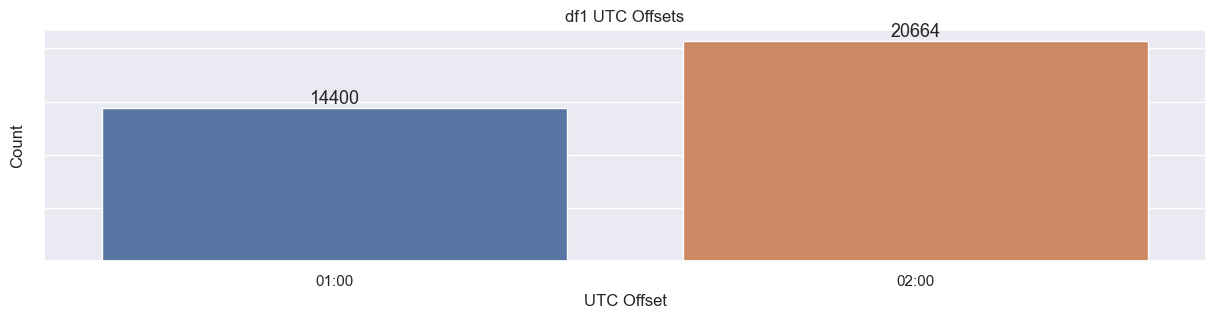

In [7]:
#Plotting a bar chart with the amount of 
sns.set(rc={"figure.figsize":(15, 3)})
f, axes = plt.subplots()
ax1 = sns.countplot(data=df1, x='UTC Offset')
ax1.set(title = 'df1 UTC Offsets')
ax1.set_xlabel('UTC Offset', fontsize = 12)
ax1.set_ylabel('Count', fontsize = 12)
ax1.set(yticklabels=[]);
ax1.bar_label(ax1.containers[0], fmt='%.f', fontsize=13);

It is possible to verify we have a mix of Offset of 1 and 2 hours. It is desirable to carry on the analysis in the time of the timezone, rather than in the time of UCT, once trends and patterns within the dataset are likely related to the time on the place measurements were taken. Therefore, the offset will be summed up to the time stamp. Before performing this step, it is necessary to convert the timestamp, so far considered only as a string, into a time series. It is important to observe that the offset might change due to changing on the time of the timezone for summer time, for instance. Therefore, once we are summing up the offset into the UCT time, we may get duplicated rows, and missing values that will need to be treated.

In [8]:
#Converting the string of column 'Time' into a time serie

df1['DateTime'] = pd.to_datetime(df1['Time'], format='%Y-%m-%d %H:%M:%S')

In [9]:
#Splitting the column Offset and converting the hour part into integer

df1['UTC Offset']=df1['UTC Offset'].str.split(':', expand=True)[0]

df1['UTC Offset']=df1['UTC Offset'].astype(int)

In [10]:
#Applying Lambda function to sum up row by row off the dataset the DateTime column with the respective offset.
#Solution found using chatGPT.

df1['DateTime'] = df1.apply(lambda row: row['DateTime'] + pd.DateOffset(hours=row['UTC Offset']), axis=1)

In [11]:
#Visualizing the first 5 rows of the dataset.

df1['DateTime'].head()

0   2015-01-01 01:00:00
1   2015-01-01 02:00:00
2   2015-01-01 03:00:00
3   2015-01-01 04:00:00
4   2015-01-01 05:00:00
Name: DateTime, dtype: datetime64[ns]

In [12]:
#Verifying duplicate rows on the time stamp

df1['DateTime'].duplicated().sum()

8

As it was observed before, 8 duplicated rows were found. As the amount is very small compared to the size of the dataset, those observations will be dropped.

Once some rows will be dropped, we will loose some of the timestamps. It is necessary to assure that the timeseries is regular, or that it contains regular intervals, to assure this, it will be considered the range of the dataset, and a new time series containing all the datapoints in the range of the dataset will be created and inserted on the original dataset. 

In [13]:
#Dropping duplicate rows

df1.drop_duplicates(subset = 'DateTime', inplace=True)

In [14]:
#Creating the datarange to assure the dataset contain all the points

start_date = df1['DateTime'].min()
finish_date = df1['DateTime'].max()
date_range = pd.date_range(start=start_date, end=finish_date, freq='1H')

In [15]:
#Setting the created DateRange to become the new index of the dataset|

df1 = df1.set_index('DateTime').reindex(date_range).reset_index()

In [16]:
df1.head()

index                       time  generation biomass  \
0 2015-01-01 01:00:00  2015-01-01 00:00:00+01:00               447.0   
1 2015-01-01 02:00:00  2015-01-01 01:00:00+01:00               449.0   
2 2015-01-01 03:00:00  2015-01-01 02:00:00+01:00               448.0   
3 2015-01-01 04:00:00  2015-01-01 03:00:00+01:00               438.0   
4 2015-01-01 05:00:00  2015-01-01 04:00:00+01:00               428.0   

   generation fossil brown coal/lignite  generation fossil coal-derived gas  \
0                                 329.0                                 0.0   
1                                 328.0                                 0.0   
2                                 323.0                                 0.0   
3                                 254.0                                 0.0   
4                                 187.0                                 0.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0                       4821.0                  162.0   
1                 5196.0                       4755.0                  158.0   
2                 4857.0                       4581.0                  157.0   
3                 4314.0                       4131.0                  160.0   
4                 4130.0                       3840.0                  156.0   

   generation fossil oil shale  generation fossil peat  ...  \
0                          0.0                     0.0  ...   
1                          0.0                     0.0  ...   
2                          0.0                     0.0  ...   
3                          0.0                     0.0  ...   
4                          0.0                     0.0  ...   

   generation wind onshore  forecast solar day ahead  \
0                   6378.0                      17.0   
1                   5890.0                      16.0   
2                   5461.0                       8.0   
3                   5238.0                       2.0   
4                   4935.0                       9.0   

   forecast wind offshore eday ahead  forecast wind onshore day ahead  \
0                                NaN                           6436.0   
1                                NaN                           5856.0   
2                                NaN                           5454.0   
3                                NaN                           5151.0   
4                                NaN                           4861.0   

   total load forecast  total load actual  price day ahead  price actual  \
0              26118.0            25385.0            50.10         65.41   
1              24934.0            24382.0            48.10         64.92   
2              23515.0            22734.0            47.33         64.48   
3              22642.0            21286.0            42.27         59.32   
4              21785.0            20264.0            38.41         56.04   

                  Time  UTC Offset  
0  2015-01-01 00:00:00         1.0  
1  2015-01-01 01:00:00         1.0  
2  2015-01-01 02:00:00         1.0  
3  2015-01-01 03:00:00         1.0  
4  2015-01-01 04:00:00         1.0  

[5 rows x 32 columns]

The next step will be verifying our dataset to discard columns that might be useless in our analysis. Let us verify the distribution of the variables of the dataset 1. 

In [17]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 32 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   index                                        35064 non-null  datetime64[ns]
 1   time                                         35056 non-null  object        
 2   generation biomass                           35037 non-null  float64       
 3   generation fossil brown coal/lignite         35038 non-null  float64       
 4   generation fossil coal-derived gas           35038 non-null  float64       
 5   generation fossil gas                        35038 non-null  float64       
 6   generation fossil hard coal                  35038 non-null  float64       
 7   generation fossil oil                        35037 non-null  float64       
 8   generation fossil oil shale                  35038 non-null  float64       


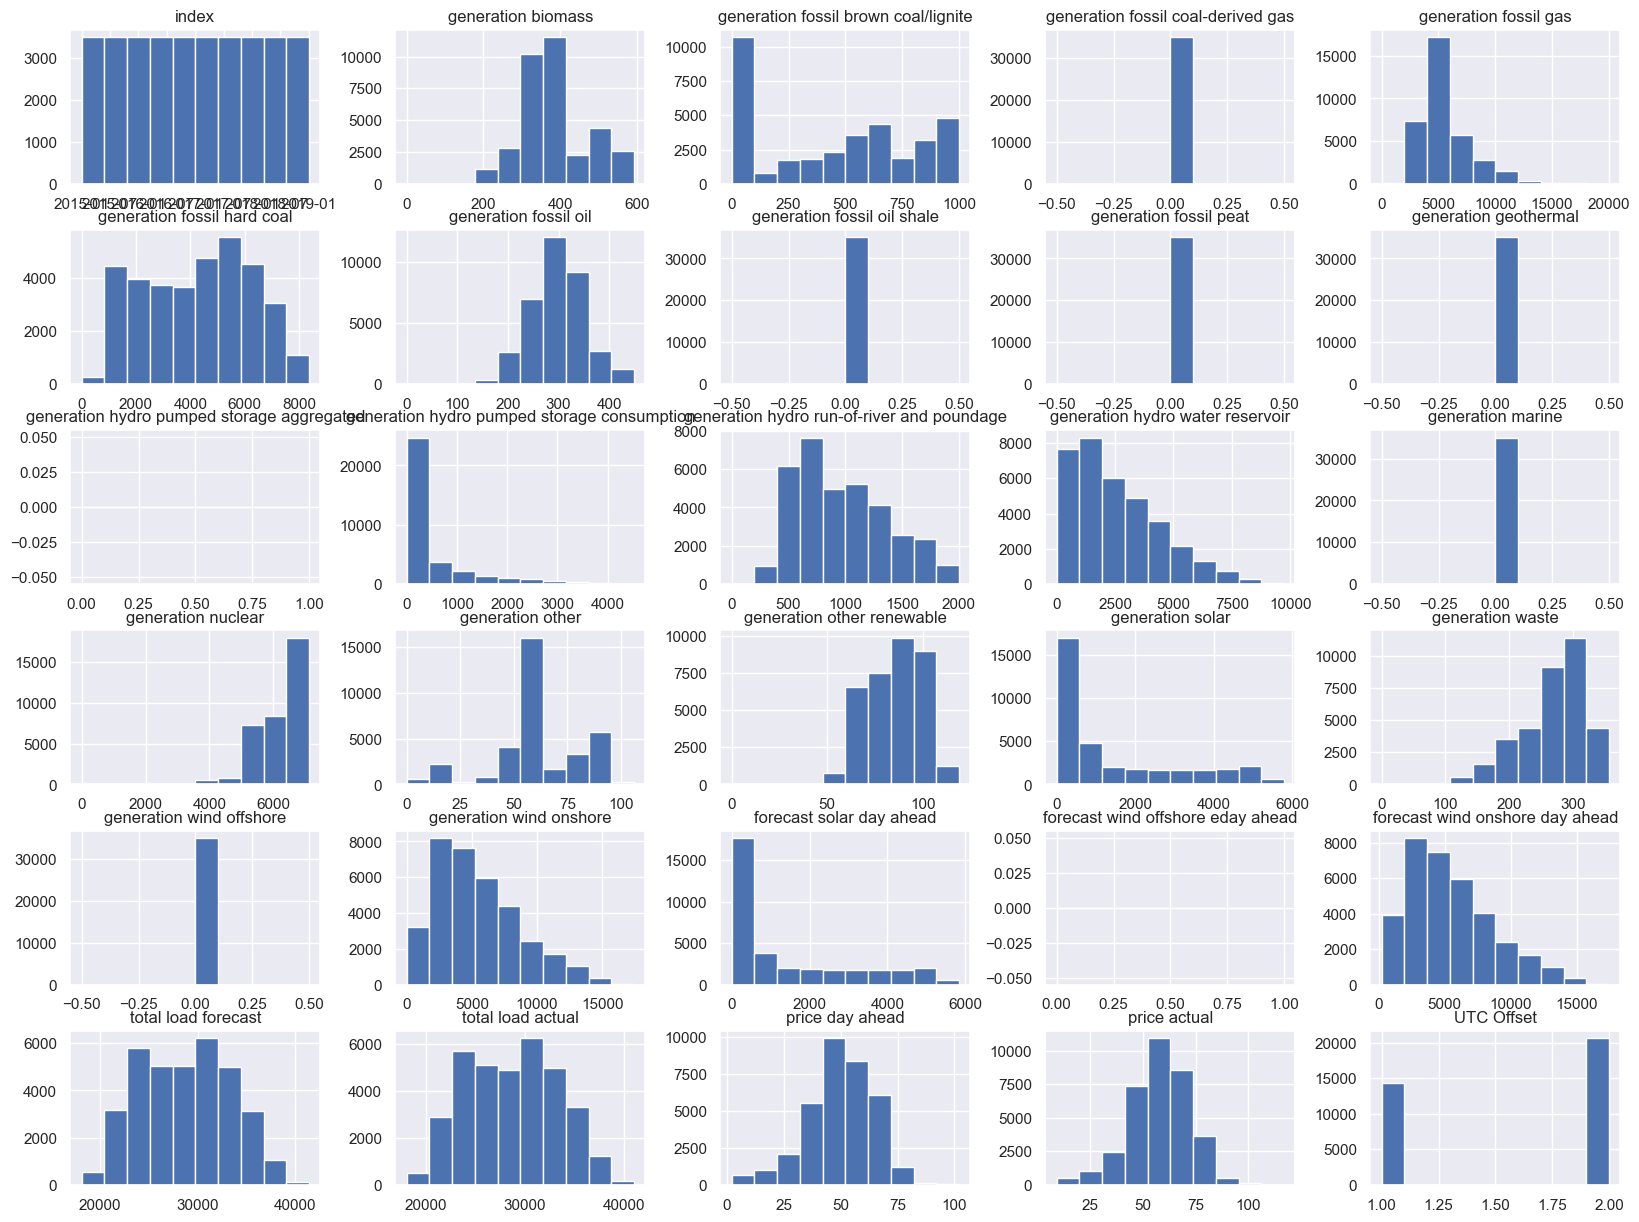

In [18]:
#Printing out histogram to all the variables on the dataset.

sns.set(rc={"figure.figsize":(20, 15)})
df1.hist();

In [19]:
#Verifying whether the feature is composed only by 0's.

df1['generation fossil coal-derived gas'].nunique(), df1['generation fossil peat'].nunique(), df1['generation geothermal'].nunique(), df1['generation fossil oil shale'].nunique(), df1['generation marine'].nunique(), df1['generation wind offshore'].nunique()



(1, 1, 1, 1, 1, 1)

It is possible to verify that the dataset only contain null values to 'generation fossil coal-derived gas', 'generation fossil peat', 'generation geothermal', 'generation fossil oil shale', 'generation marine' and 'generation wind offshore'. Furthermore, 'generation hydro pumped storage aggregated' and 'forecast wind offshore eday ahead' contain only null values. All these features will be discarded together with the feature 'UTC Offset', 'time' and 'Time'.

In [20]:
#Dropping all the columns and replacing the original dataset for the one without the features mentioned.

df1.drop(columns = ['generation fossil coal-derived gas', 
                    'generation fossil peat', 
                    'generation geothermal', 'generation fossil oil shale', 
                    'generation marine', 'generation wind offshore',
                    'generation hydro pumped storage aggregated', 'forecast wind offshore eday ahead',
                     'UTC Offset', 'time', 'Time'], inplace = True)

The next step will be verifying and filling up null values contained our dataset.

In [21]:
df1.isna().sum()

index                                           0
generation biomass                             27
generation fossil brown coal/lignite           26
generation fossil gas                          26
generation fossil hard coal                    26
generation fossil oil                          27
generation hydro pumped storage consumption    27
generation hydro run-of-river and poundage     27
generation hydro water reservoir               26
generation nuclear                             25
generation other                               26
generation other renewable                     26
generation solar                               26
generation waste                               27
generation wind onshore                        26
forecast solar day ahead                        8
forecast wind onshore day ahead                 8
total load forecast                             8
total load actual                              44
price day ahead                                 8


The amount of missing information on the dataset is very small, something close to 25 in most of the columns missing data, and the biggest amount 36, o total load actual. Those numbers count for aproximately 1% of all the observation on the data, so that the imputation method used will not highly influence the shape of the data itself. It has been chosen to imputate the values only with the mean value of each column.

In [22]:
#Filling NA values in the dataset df1

df1.fillna(df1.mean(),inplace = True)

In [23]:
df1.isna().sum().sum()

0

In [24]:
df1.shape

(35064, 21)

In [25]:
#Printing information of the dataset
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 21 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   index                                        35064 non-null  datetime64[ns]
 1   generation biomass                           35064 non-null  float64       
 2   generation fossil brown coal/lignite         35064 non-null  float64       
 3   generation fossil gas                        35064 non-null  float64       
 4   generation fossil hard coal                  35064 non-null  float64       
 5   generation fossil oil                        35064 non-null  float64       
 6   generation hydro pumped storage consumption  35064 non-null  float64       
 7   generation hydro run-of-river and poundage   35064 non-null  float64       
 8   generation hydro water reservoir             35064 non-null  float64       


By the end of our cleaning and preparation steps, our dataset contains 35064 rows and 21 columns, in which 20 are continuous and 1 is the timestamp. Afterwards we can follow on to the exploratory data analysis.

## 3- EXPLORATORY DATA ANALYSIS

The variable we are interested in this case is the total load actual, it represents the total amount of energy consumed in Spain in MWh. Let us visualize the main features of the variables. 

In [26]:
#Renaming the column index created to DateTime and setting DateTime as the index of the dataset

df1 = df1.rename(columns= {'index':'DateTime'})
df1.index = df1['DateTime']

In [27]:
df1.head()

DateTime  generation biomass  \
DateTime                                                      
2015-01-01 01:00:00 2015-01-01 01:00:00               447.0   
2015-01-01 02:00:00 2015-01-01 02:00:00               449.0   
2015-01-01 03:00:00 2015-01-01 03:00:00               448.0   
2015-01-01 04:00:00 2015-01-01 04:00:00               438.0   
2015-01-01 05:00:00 2015-01-01 05:00:00               428.0   

                     generation fossil brown coal/lignite  \
DateTime                                                    
2015-01-01 01:00:00                                 329.0   
2015-01-01 02:00:00                                 328.0   
2015-01-01 03:00:00                                 323.0   
2015-01-01 04:00:00                                 254.0   
2015-01-01 05:00:00                                 187.0   

                     generation fossil gas  generation fossil hard coal  \
DateTime                                                                  
2015-01-01 01:00:00                 4844.0                       4821.0   
2015-01-01 02:00:00                 5196.0                       4755.0   
2015-01-01 03:00:00                 4857.0                       4581.0   
2015-01-01 04:00:00                 4314.0                       4131.0   
2015-01-01 05:00:00                 4130.0                       3840.0   

                     generation fossil oil  \
DateTime                                     
2015-01-01 01:00:00                  162.0   
2015-01-01 02:00:00                  158.0   
2015-01-01 03:00:00                  157.0   
2015-01-01 04:00:00                  160.0   
2015-01-01 05:00:00                  156.0   

                     generation hydro pumped storage consumption  \
DateTime                                                           
2015-01-01 01:00:00                                        863.0   
2015-01-01 02:00:00                                        920.0   
2015-01-01 03:00:00                                       1164.0   
2015-01-01 04:00:00                                       1503.0   
2015-01-01 05:00:00                                       1826.0   

                     generation hydro run-of-river and poundage  \
DateTime                                                          
2015-01-01 01:00:00                                      1051.0   
2015-01-01 02:00:00                                      1009.0   
2015-01-01 03:00:00                                       973.0   
2015-01-01 04:00:00                                       949.0   
2015-01-01 05:00:00                                       953.0   

                     generation hydro water reservoir  generation nuclear  \
DateTime                                                                    
2015-01-01 01:00:00                            1899.0              7096.0   
2015-01-01 02:00:00                            1658.0              7096.0   
2015-01-01 03:00:00                            1371.0              7099.0   
2015-01-01 04:00:00                             779.0              7098.0   
2015-01-01 05:00:00                             720.0              7097.0   

                     ...  generation other renewable  generation solar  \
DateTime             ...                                                 
2015-01-01 01:00:00  ...                        73.0              49.0   
2015-01-01 02:00:00  ...                        71.0              50.0   
2015-01-01 03:00:00  ...                        73.0              50.0   
2015-01-01 04:00:00  ...                        75.0              50.0   
2015-01-01 05:00:00  ...                        74.0              42.0   

                     generation waste  generation wind onshore  \
DateTime                                                         
2015-01-01 01:00:00             196.0                   6378.0   
2015-01-01 02:00:00             195.0                   5890.0   
2015-01-01 03:00:00             196.0     

In [28]:
## Printing the descriptive analysis of the target variable.

df1['total load actual'].describe()

count    35064.000000
mean     28698.996488
std       4570.615019
min      18041.000000
25%      24812.000000
50%      28894.000000
75%      32186.250000
max      41015.000000
Name: total load actual, dtype: float64

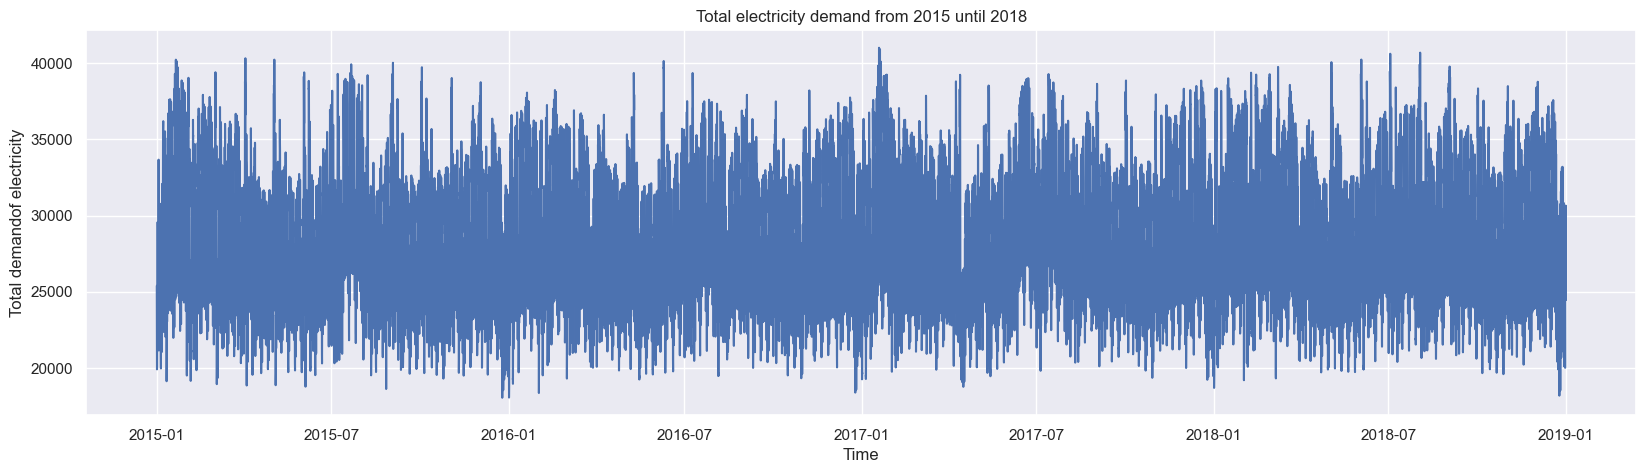

In [29]:
##Printing the timeseries to visualise it graphycally

sns.set(rc={"figure.figsize":(20, 5)})
fig, ax = plt.subplots()

ax.plot(df1['DateTime'], df1['total load actual'])
plt.title('Total electricity demand from 2015 until 2018')
ax.set_xlabel('Time')
ax.set_ylabel('Total demandof electricity');

To try to make the graph more visual, let us plot the moving average of the data.

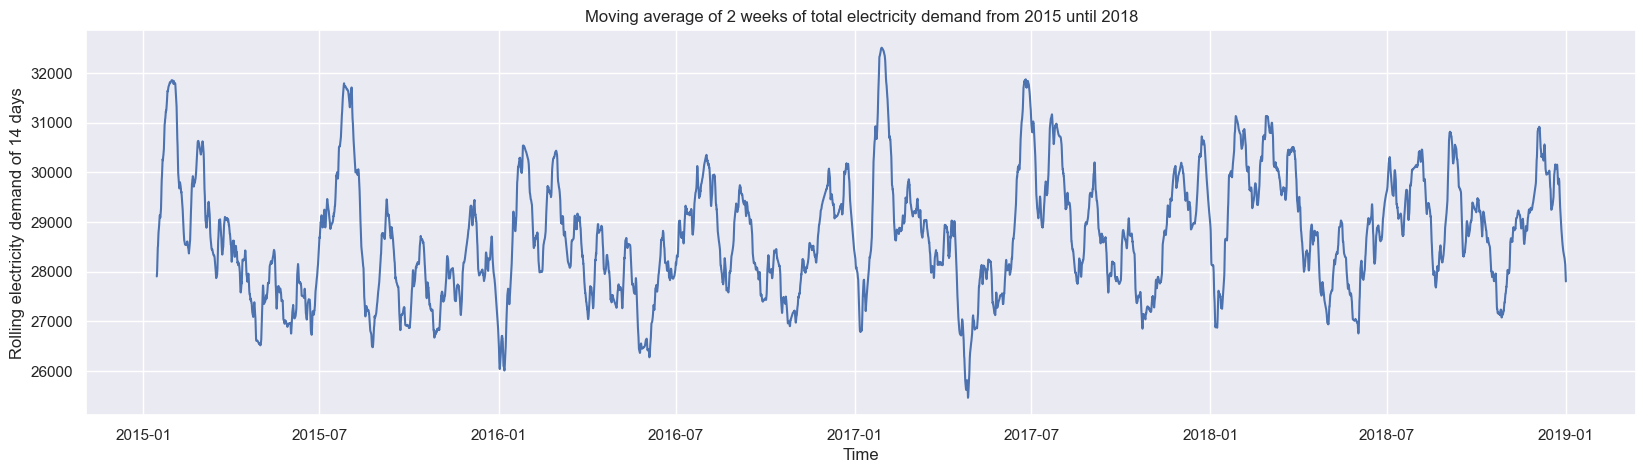

In [30]:
#Applying a moving average of 14 days on the dataset. 14*7 = 336 hours.

sns.set(rc={"figure.figsize":(20, 5)})
fig, ax = plt.subplots()

df1['2weeksaverage'] = df1['total load actual'].rolling(window = 336).mean()

ax.plot(df1['DateTime'], df1['2weeksaverage'])
plt.title('Moving average of 2 weeks of total electricity demand from 2015 until 2018')
ax.set_xlabel('Time')
ax.set_ylabel('Rolling electricity demand of 14 days');

It is possible to verify primarily, that it seems that every year has 2 peaks of electricity consumption, one around January, and another one around July. The data will be plot in 3 different zooms, so that we can identify some patterns hidden on the data.
The descriptive analysis of the data shows that the total demand hold the following properties:
<br>Min: 18041.00 MWh
<br>Mean: 27697.95 MWh
<br>Max: 41015.00 MWh

The average of electricity demand of Spain from 2015 until 2018 is 27697.95 MWh. 

It is also possible to verify that apparently the data does not contain any strong trend, and by the graphs we can identify the complexity of the task. It is not possible to identify much of patterns beforehand on the graphs.

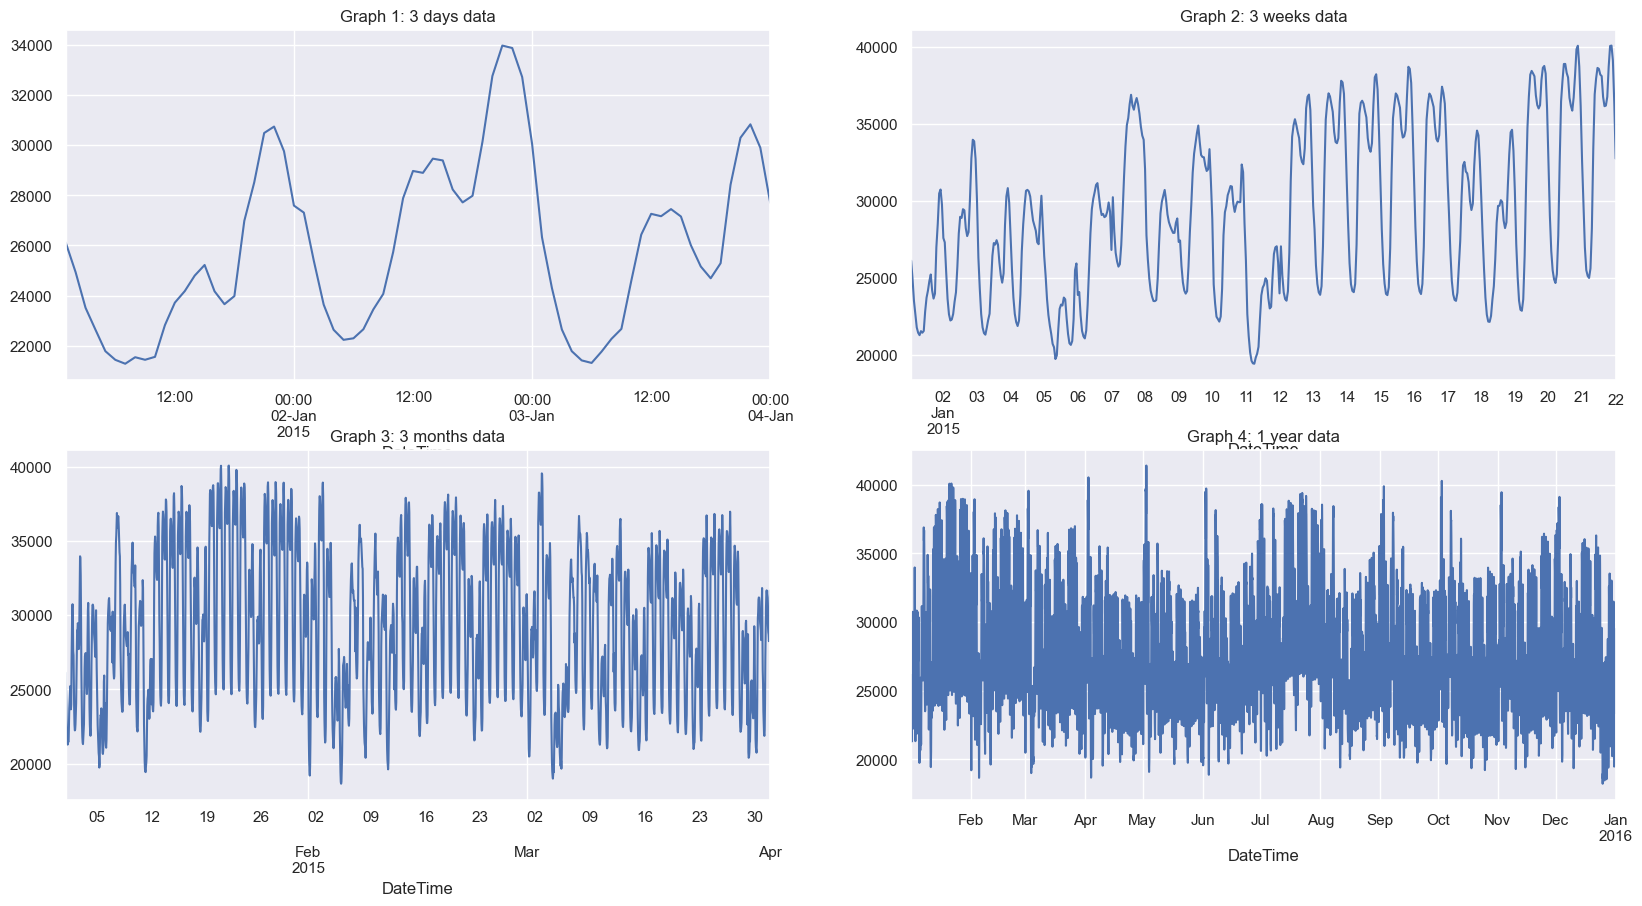

In [31]:
#Plotting our target variable in three different zooms

sns.set(rc={"figure.figsize":(20,10)})
fig, ax = plt.subplots(2,2)

df1.iloc[:72, 17].plot(ax = ax[0,0], title='Graph 1: 3 days data')

df1.iloc[:504, 17].plot(ax = ax[0,1], title='Graph 2: 3 weeks data')

df1.iloc[:2160, 17].plot(ax = ax[1,0], title='Graph 3: 3 months data')

df1.iloc[:8760, 17].plot(ax = ax[1,1], title='Graph 4: 1 year data');

To verify the dataset more in depth, the DateTime series will be separated in different columns, this methodology was used by (Pawar, 2020).

In [32]:
#Converting DateTime in different columns.

weekdays = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3: 'Thursday', 4: 'Friday', 5:'Saturday', 6:'Sunday'}
months = {1: 'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6: 'Jun', 7:'Jul', 8:'Ago', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'} 
df1['year']=df1['DateTime'].dt.year
df1['month']=df1['DateTime'].dt.month
df1['day']=df1['DateTime'].dt.day
df1['hour']=df1['DateTime'].dt.hour
df1['weekday']=df1['DateTime'].dt.weekday

In [33]:
#Visualizing the first 5 rows of the dataset.

df1.head()

DateTime  generation biomass  \
DateTime                                                      
2015-01-01 01:00:00 2015-01-01 01:00:00               447.0   
2015-01-01 02:00:00 2015-01-01 02:00:00               449.0   
2015-01-01 03:00:00 2015-01-01 03:00:00               448.0   
2015-01-01 04:00:00 2015-01-01 04:00:00               438.0   
2015-01-01 05:00:00 2015-01-01 05:00:00               428.0   

                     generation fossil brown coal/lignite  \
DateTime                                                    
2015-01-01 01:00:00                                 329.0   
2015-01-01 02:00:00                                 328.0   
2015-01-01 03:00:00                                 323.0   
2015-01-01 04:00:00                                 254.0   
2015-01-01 05:00:00                                 187.0   

                     generation fossil gas  generation fossil hard coal  \
DateTime                                                                  
2015-01-01 01:00:00                 4844.0                       4821.0   
2015-01-01 02:00:00                 5196.0                       4755.0   
2015-01-01 03:00:00                 4857.0                       4581.0   
2015-01-01 04:00:00                 4314.0                       4131.0   
2015-01-01 05:00:00                 4130.0                       3840.0   

                     generation fossil oil  \
DateTime                                     
2015-01-01 01:00:00                  162.0   
2015-01-01 02:00:00                  158.0   
2015-01-01 03:00:00                  157.0   
2015-01-01 04:00:00                  160.0   
2015-01-01 05:00:00                  156.0   

                     generation hydro pumped storage consumption  \
DateTime                                                           
2015-01-01 01:00:00                                        863.0   
2015-01-01 02:00:00                                        920.0   
2015-01-01 03:00:00                                       1164.0   
2015-01-01 04:00:00                                       1503.0   
2015-01-01 05:00:00                                       1826.0   

                     generation hydro run-of-river and poundage  \
DateTime                                                          
2015-01-01 01:00:00                                      1051.0   
2015-01-01 02:00:00                                      1009.0   
2015-01-01 03:00:00                                       973.0   
2015-01-01 04:00:00                                       949.0   
2015-01-01 05:00:00                                       953.0   

                     generation hydro water reservoir  generation nuclear  \
DateTime                                                                    
2015-01-01 01:00:00                            1899.0              7096.0   
2015-01-01 02:00:00                            1658.0              7096.0   
2015-01-01 03:00:00                            1371.0              7099.0   
2015-01-01 04:00:00                             779.0              7098.0   
2015-01-01 05:00:00                             720.0              7097.0   

                     ...  total load forecast  total load actual  \
DateTime             ...                                           
2015-01-01 01:00:00  ...              26118.0            25385.0   
2015-01-01 02:00:00  ...              24934.0            24382.0   
2015-01-01 03:00:00  ...              23515.0            22734.0   
2015-01-01 04:00:00  ...              22642.0            21286.0   
2015-01-01 05:00:00  ...              21785.0            20264.0   

                     price day ahead  price actual  2weeksaverage  year  \
DateTime                                                                  
2015-01-01 01:00:00            50.10         65.41            NaN  2015   
2015-01-01 02:00:00            48.10         64.92            NaN  2015   
2015-01-01 03:00:00            47.33         64.

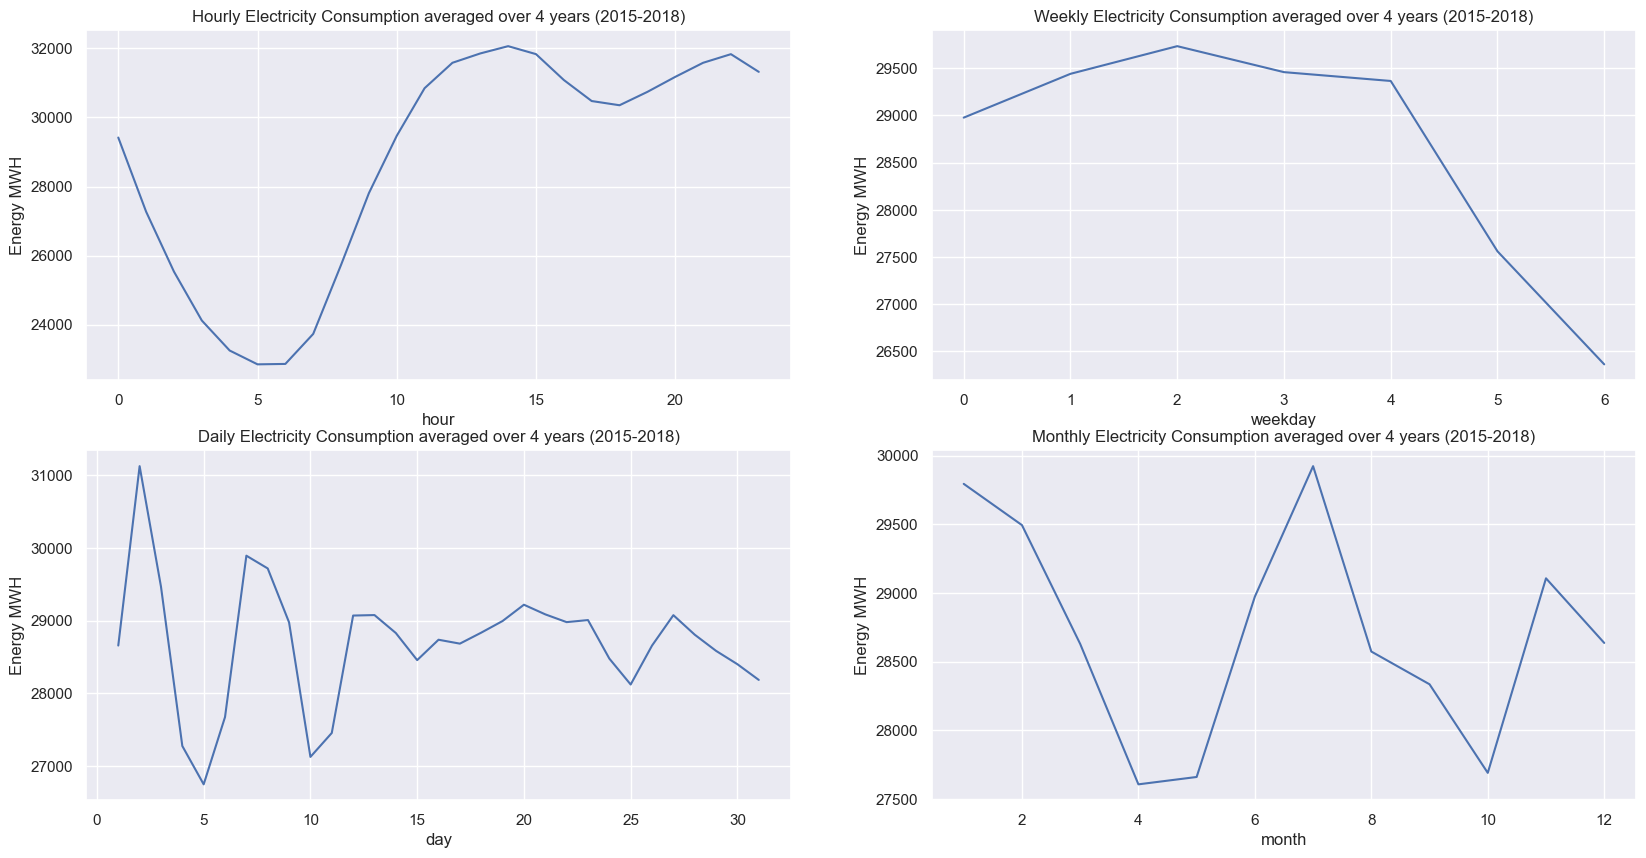

In [34]:
#Verifying average of energy consumption through function groupby

sns.set(rc={"figure.figsize":(20,10)})
fig, ax = plt.subplots(2,2)

df1.groupby('hour')['total load actual'].mean().plot(ax = ax[0,0], title = 'Hourly Electricity Consumption averaged over 4 years (2015-2018)')
df1.groupby('day')['total load actual'].mean().plot(ax = ax[1,0], title = 'Daily Electricity Consumption averaged over 4 years (2015-2018)')
df1.groupby('weekday')['total load actual'].mean().plot(ax = ax[0,1], title = 'Weekly Electricity Consumption averaged over 4 years (2015-2018)')
df1.groupby('month')['total load actual'].mean().plot(ax = ax[1,1], title = 'Monthly Electricity Consumption averaged over 4 years (2015-2018)')

ax[0,0].set_ylabel('Energy MWH')
ax[0,1].set_ylabel('Energy MWH')
ax[1,0].set_ylabel('Energy MWH')
ax[1,1].set_ylabel('Energy MWH');

It is possible to verify some patterns when looking to the data averaged by different periods of time. It seems that overall when looking to daily data, the demand of energy decreases from around 23 until 05, when it reaches a minimum, and than it increases reaching a local peak around 14, and another peak around 22. 

Weekly data seems to be consumed somewhat regularly from day 0 until day 4, what represents from Monday until Friday, what are commonly working days, and than it decreases through the weekend, reaching a minimum on day 6, which is Sunday. That indicates pattern within the data throughout weeks. 

Daily data observed through a month window seems to behave randomly throughout the month. There is no clear pattern immediatily possible to be identified.

The monthly data observed through a year window shows a peak on January, that decreases reaching a minimum in April. From April until May values are levelled, when they increase again reaching another peak in July. Values will decrease towards a minimum in October, and than increase again until January. Those periods match with the changing on the seasons, and consequently, probably with increasing and decreasing of temperature. 

The next step will be verifying whether the patterns observed in the graphs above repeats throughout our dataset, what would turn them into seasonal patterns or cyclical patterns. 

### 3.2.1- Analysing seasonalities

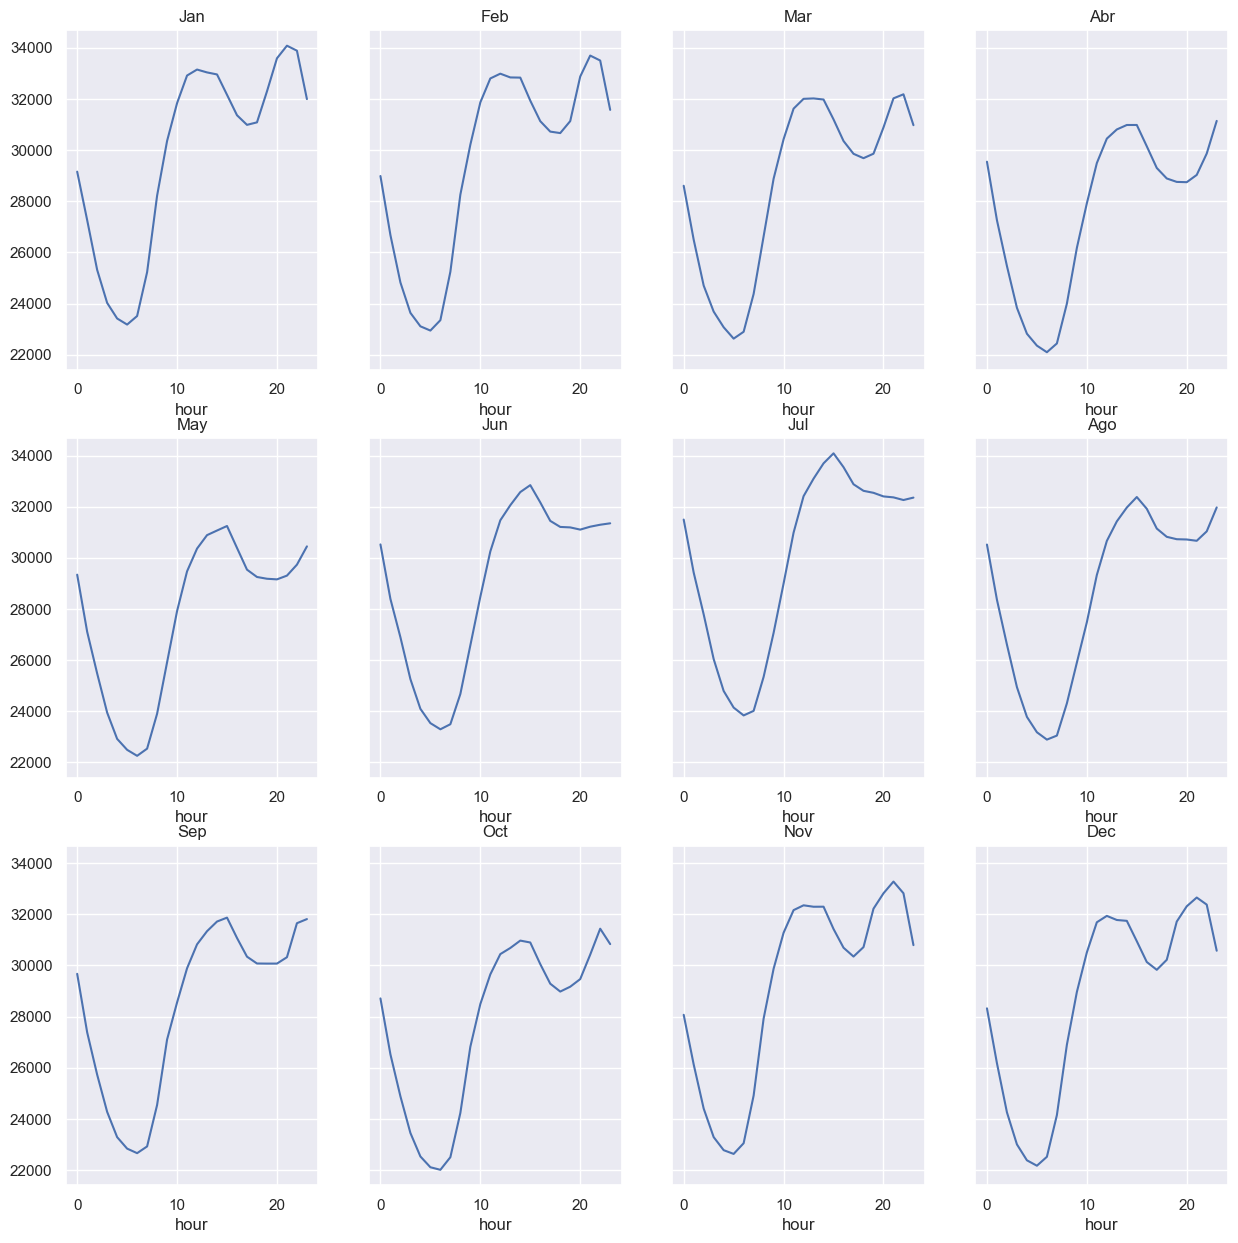

In [35]:
##https://towardsdatascience.com/multi-seasonal-time-series-decomposition-using-mstl-in-python-136630e67530
#Plotting daily behavior averaged by hour in each month of our data.

fig, ax = plt.subplots(nrows=3, ncols=4, figsize=[15, 15], sharey=True)
ax = ax.flatten()
MONTHS = ['Jan','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dec']
for ix, month in enumerate(MONTHS):
    df1.groupby(by=['month', 'hour'])['total load actual'].mean()[ix+1].plot(ax = ax[ix])
    ax[ix].set_title(month)

It is possible to see that exists an hourly correlation. When looking to the data monthly, it is clearly that a simillar pattern repeats itself everyday throughout the months. It is possible to see that one more clear peak is present from May until September, usually the warmer season of the year, and also the season with longer daylight. It is also possible to notice that the consume is in a level slightly higher than the colder season, problably for a constant need for cooling facilities. On the other hand, from October until Abril, the line draws a more clear second peak of electricty demand after 8, probably for need of heating facilities, and also a higher use of electrical lights. The graphs show a daily seasonality, that will need to be removed onwards. 

Let us verify now how a autocorrelation graph and partial autocorrelation show this pattern.

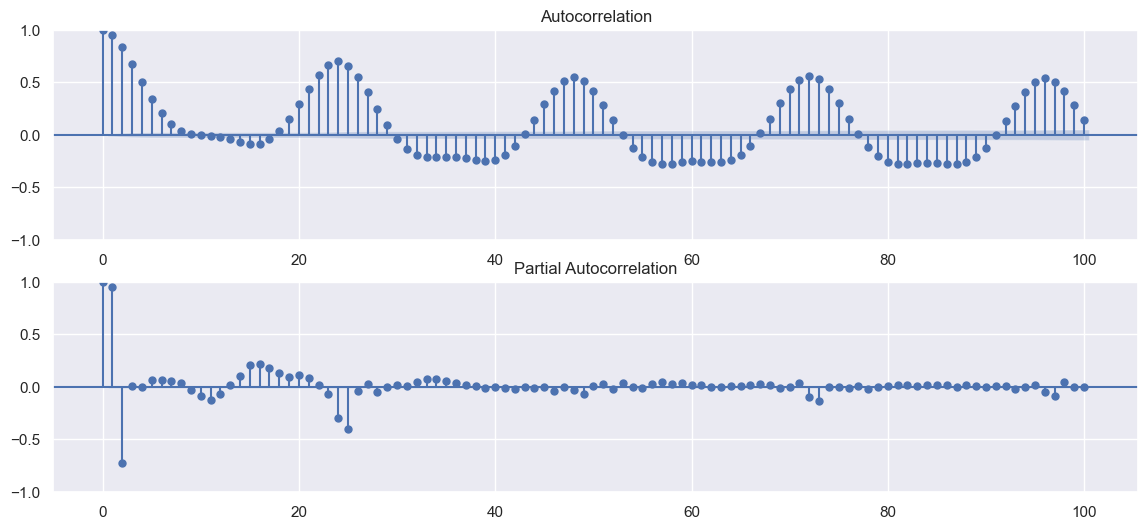

In [36]:
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df1['total load actual'],lags = 100,ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df1['total load actual'],lags = 100,ax = ax2)

As expected, we can see that the Autocorrelation graph shows a strong correlation with past values in the lag 24, representing the hourly seasonality that has been discussed.

Let us verify now the weekly pattern seen before.

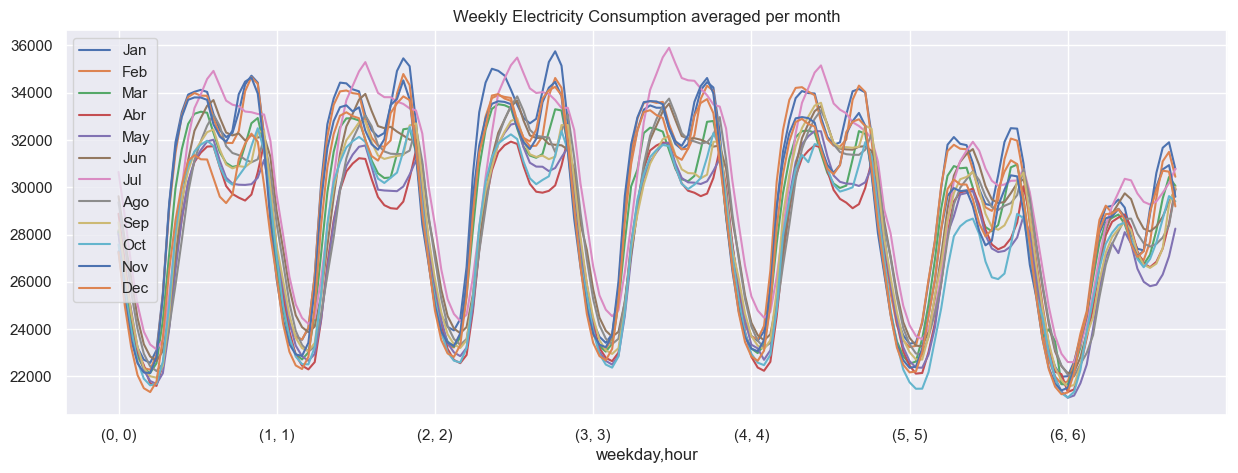

In [37]:
##Plotting overlapping months for weekly demand of energy

for ix, month in enumerate(MONTHS):
    df1.groupby(by=['month','weekday','hour'])['total load actual'].mean()[ix+1].plot(title = 'Weekly Electricity Consumption averaged per month',
                                                                             figsize = (15,5), 
                                                                             legend = True,
                                                                             label = month)

As it is possible to verify from the graph above, it seems that the are also a seasonality within the days of the week, what means that at every 7 days, or something around 168 hours, the same pattern will repeat. To verify this, it will be plotted a resampled version of hour dataset, resampling it from hourly to daily series.

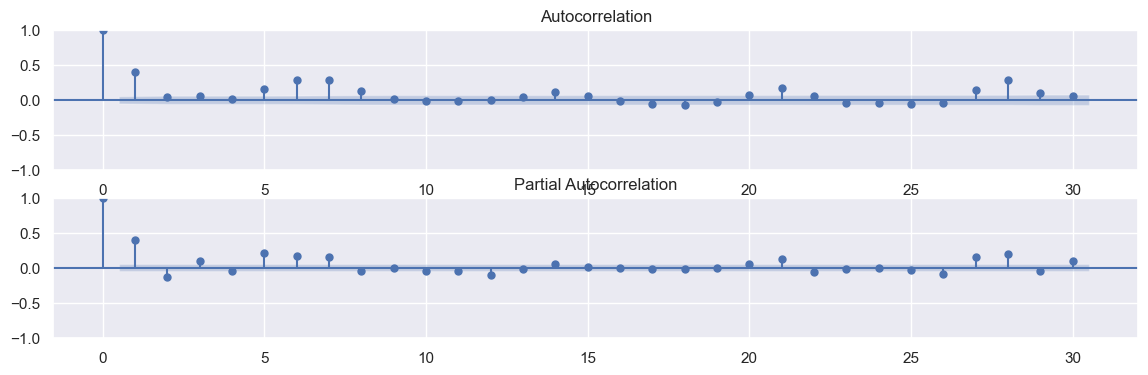

In [38]:
##Plotting the autocorrelation and partial autocorrelation graphs for the data resampled to daily using the mean
fig = plt.figure(figsize = (14, 4))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df1.resample('D').mean()['total load actual'],lags = 30,ax = ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df1.resample('D').mean()['total load actual'],lags = 30,ax = ax2)

As it is possible to verify, although the peaks perceived in this case are smoother than the ones we found when verifying daily data, they are still present, and they account for weekly seasonality on the data, which will also need to be removed when creating our machine learning model.

Now we will verify monthly cycles, to verify if any patterns repets along months, or along each 30 days.

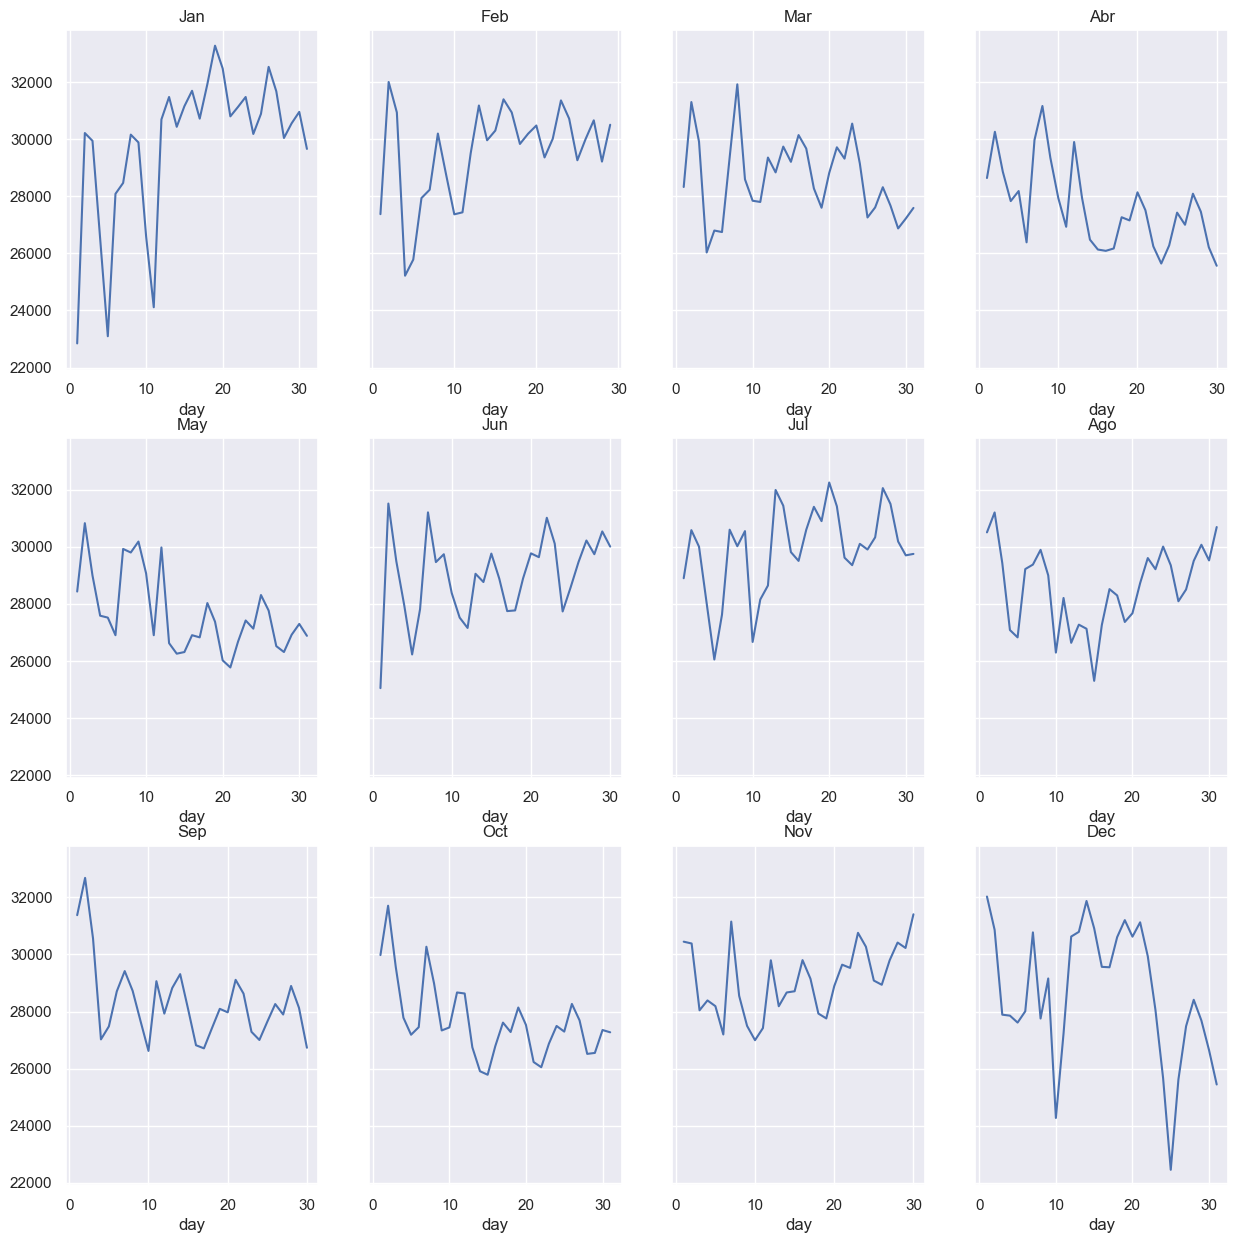

In [39]:
#Plotting monhtly behavior averaged by day in each month of our data.

fig, ax = plt.subplots(nrows=3, ncols=4, figsize=[15, 15], sharey=True)
ax = ax.flatten()
MONTHS = ['Jan','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dec']
for ix, month in enumerate(MONTHS):
    df1.groupby(by=['month', 'day'])['total load actual'].mean()[ix+1].plot(ax = ax[ix])
    ax[ix].set_title(month)

As we can verify from the graph above, we cannot verify any repetitive pattern within the days of the month. That probably happens because there is no clear reasons for patterns being created along days of the month, and they therefore seem pretty random. 

The last step will be verifying seasonality along years.

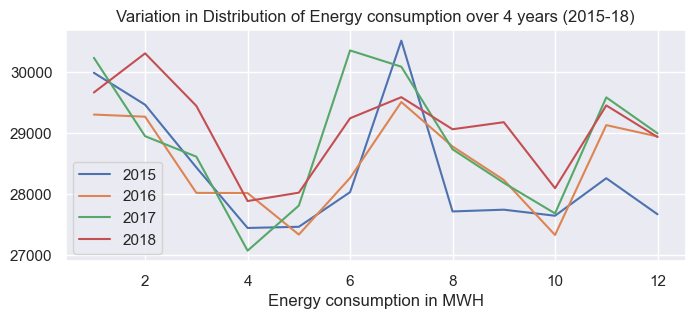

In [40]:
#Plotting yearly overlapping graphs averaged by month.

for year in [2015,2016,2017,2018]:
    df1.groupby(by=['year', 'month'])['total load actual'].mean()[year].plot(title = 'Monthly Electricity Consumption averaged over 4 years (2015-2018)',
                                                                             figsize = (8,3), 
                                                                             legend = True,
                                                                             label = year)
    plt.xlabel('Energy consumption in MWH')
    plt.title('Variation in Distribution of Energy consumption over 4 years (2015-18)')

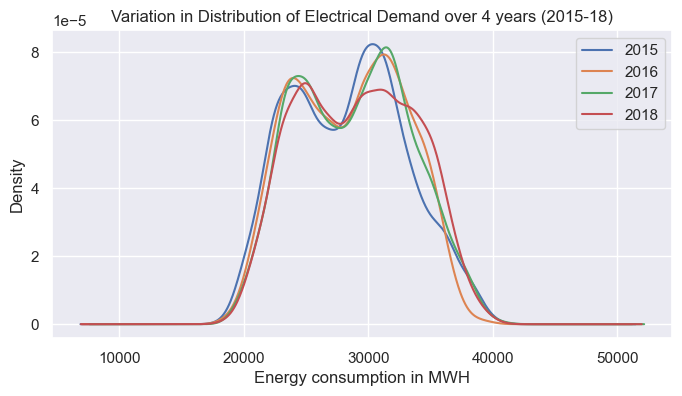

In [41]:
#Plotting density plots to verify the distribution eletrical demand from 2015 until 2018

for year in [2015,2016,2017,2018]:
    df1[df1['year'] == year]['total load actual'].plot(kind='density', figsize = (8,4), legend = True, label = year)
    plt.xlabel('Energy consumption in MWH')
    plt.title('Variation in Distribution of Electrical Demand over 4 years (2015-18)')

As we can verify and as we have mentioned before, energy reaches two peaks on the year, one around January, and one around July. However they have different intensities as it is possible to be verified through the distribution of the values. It is more likely that by the end of the year, the peak is slightly lower than by the middle of the year. Another important aspect to be observed, is that apparently some event has happenend on 2018, by the middle of the year that reduced the consume of electricity in Spain. Nevertheless, it is possible to see through the distribution graph a high similarity, and therefore, it will be considered in this project the presence of an yearly seasonality, what in our case, represence a seasonality in periods of 8766 hours. 

In conclusion, we will consider in this study, based on the exploration carried out so far, the presence of three seasonalities in the data:
<br> 1- Daily - 24 hours.
<br> 2- Weekly - 168 hours.
<br> 3- Yearly - 8766 hours.

### 3.2.2- Analysing changing of variance

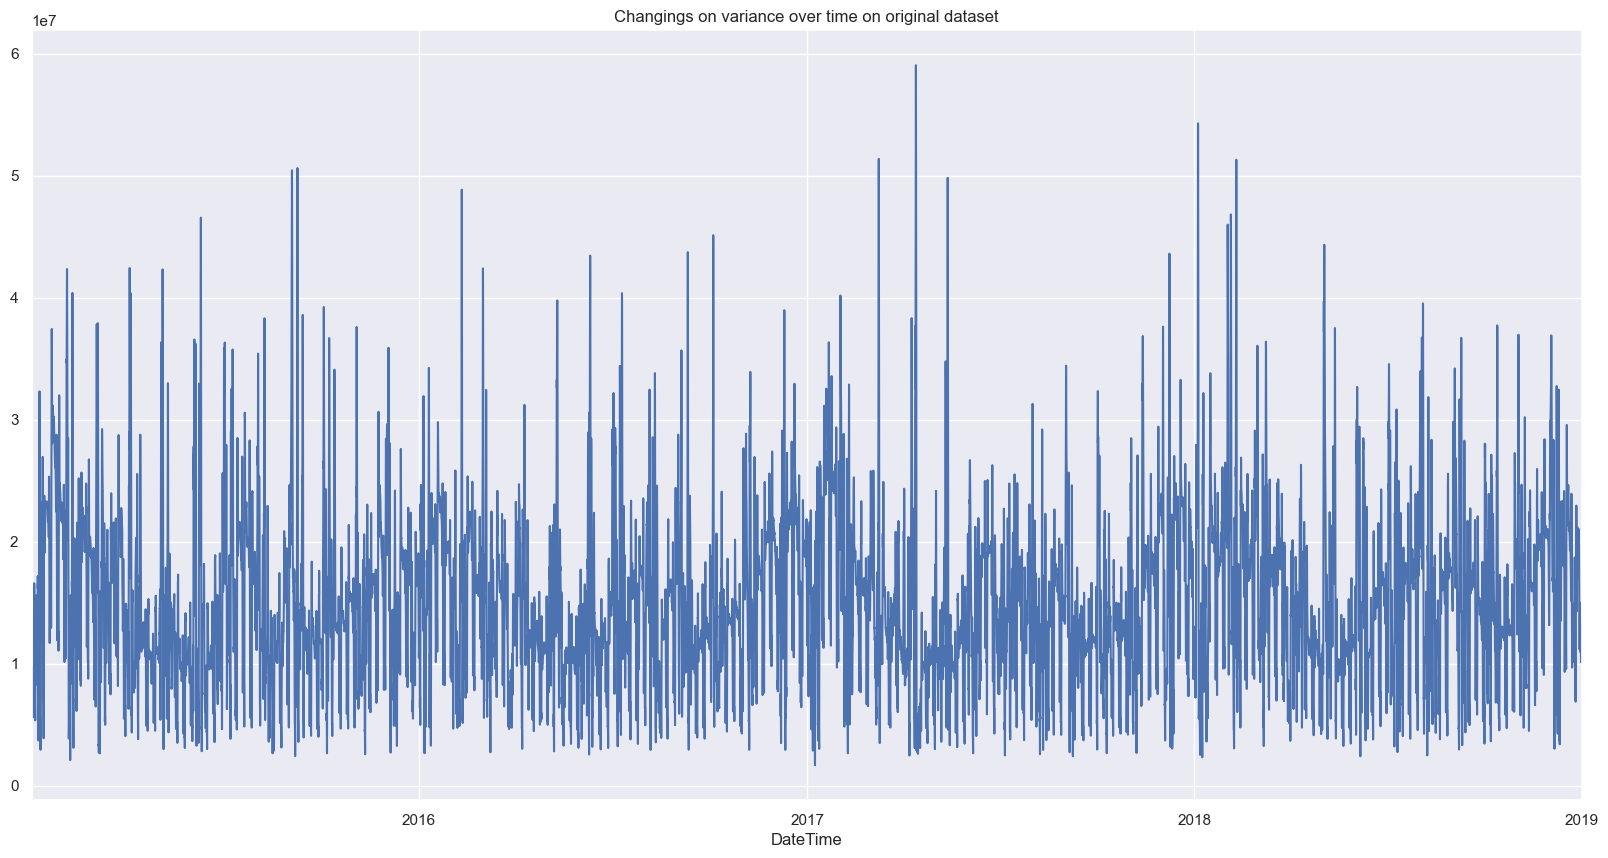

In [42]:
##Plotting variance over time

df1['total load actual'].rolling(window = 24).var().plot()
plt.title('Changings on variance over time on original dataset');

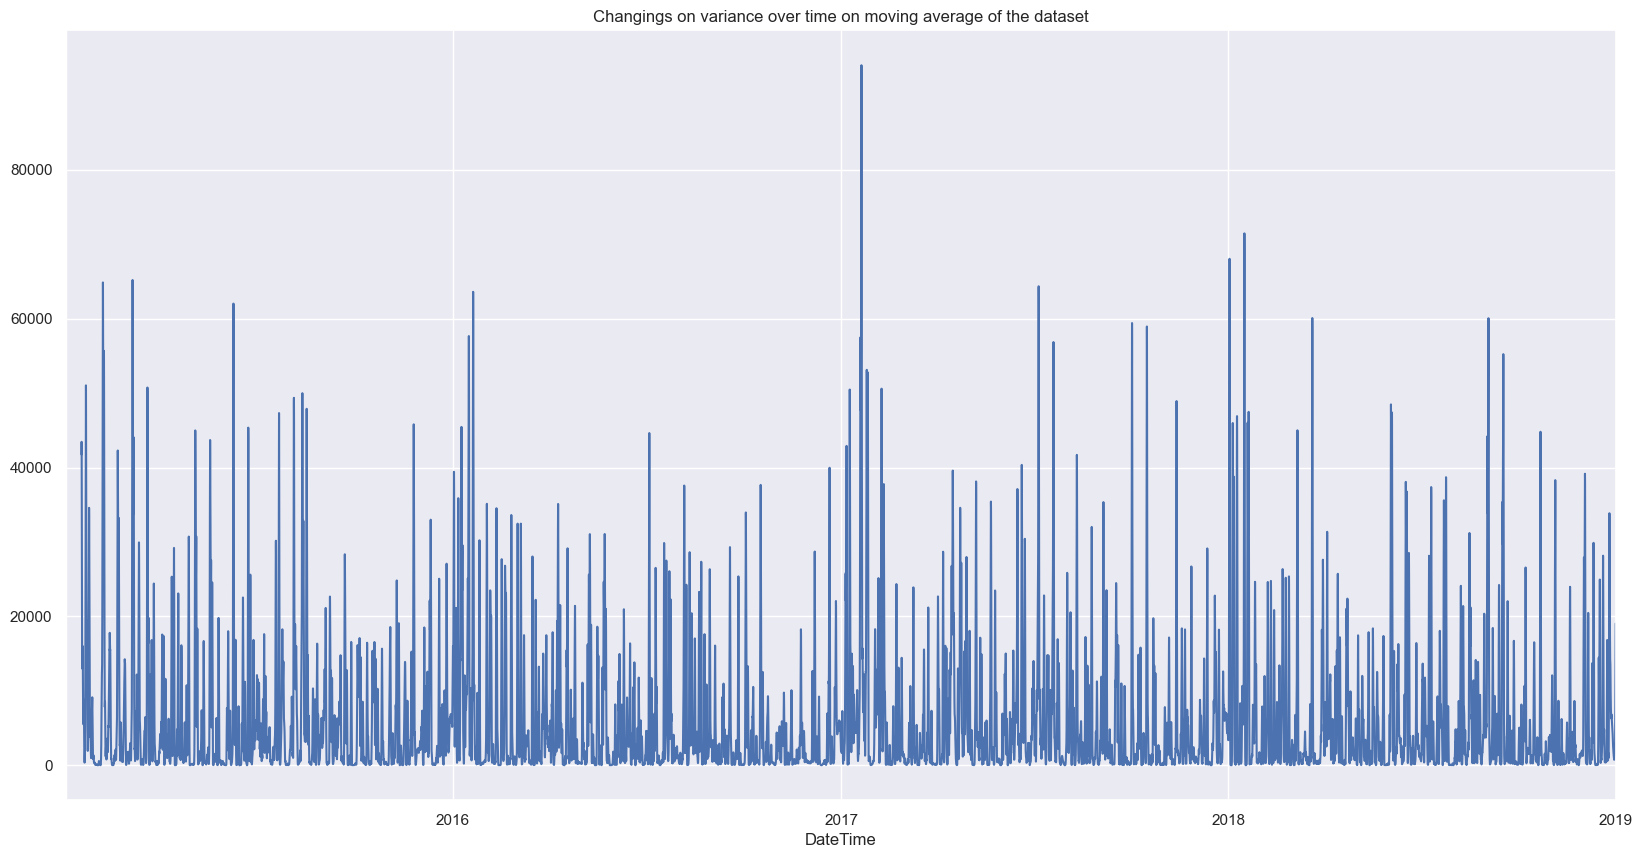

In [43]:
##Plotting variance on a 2 weeks averaged variable over time

df1['2weeksaverage'].rolling(window = 24).var().plot()
plt.title('Changings on variance over time on moving average of the dataset');

It is possible to verify that although the variance on the dataset fluctuates, it does not increase or decrease over time. Therefore the variance will not be an issue in regards to stationarity. 

# 4- PREDICTING OUR DATA THROUGH DIFFERENT METHODS

As it was stated before, our main goal is predicting our data in a windows of 2 months, what is equivalent in hour dataset to a period of 1465 hours. To proceed this task, we will first split our dataset in training and testing, and we will create our training dataset with the same amount of observations that we want to predict, rather than choosing an arbitrary percentage. In the sequence, it will be created through trivil methods, baselines that will be used to be compared with the models built, and will be useful to analyse whether the models can outperform the trivial solutions. 

The explanation of how 1465 hours were defined is below.

In [44]:
#Visualizing how many observations are present after 2018-11-01 00:00:00 to define our 2 months window.

df1[df1.index >= '2018-11-01 00:00:00'].shape

(1465, 27)

## 4.1 - Splitting the dataset into training and testing

In [45]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2015-01-01 01:00:00 to 2019-01-01 00:00:00
Data columns (total 27 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   DateTime                                     35064 non-null  datetime64[ns]
 1   generation biomass                           35064 non-null  float64       
 2   generation fossil brown coal/lignite         35064 non-null  float64       
 3   generation fossil gas                        35064 non-null  float64       
 4   generation fossil hard coal                  35064 non-null  float64       
 5   generation fossil oil                        35064 non-null  float64       
 6   generation hydro pumped storage consumption  35064 non-null  float64       
 7   generation hydro run-of-river and poundage   35064 non-null  float64       
 8   generation hydro water reservoir         

In [46]:
#Splitting the dataset into training and testing

training = df1[:-1465]
testing = df1[-1465:]
training = training.iloc[:, [18,22,23,24,25,26]]
testing = testing.iloc[:, [18,22,23,24,25,26]]

#Displaying the rows and columns of training and testing datasets
training.shape, testing.shape

((33599, 6), (1465, 6))

In [47]:
training.head()

total load actual  year  month  day  hour  weekday
DateTime                                                               
2015-01-01 01:00:00            25385.0  2015      1    1     1        3
2015-01-01 02:00:00            24382.0  2015      1    1     2        3
2015-01-01 03:00:00            22734.0  2015      1    1     3        3
2015-01-01 04:00:00            21286.0  2015      1    1     4        3
2015-01-01 05:00:00            20264.0  2015      1    1     5        3

In [48]:
testing.head()

total load actual  year  month  day  hour  weekday
DateTime                                                               
2018-11-01 00:00:00            28361.0  2018     11    1     0        3
2018-11-01 01:00:00            28830.0  2018     11    1     1        3
2018-11-01 02:00:00            26646.0  2018     11    1     2        3
2018-11-01 03:00:00            25233.0  2018     11    1     3        3
2018-11-01 04:00:00            24749.0  2018     11    1     4        3

## 4.2- Building a baseline solution to the forescasting problem

### 4.2.1- Predicting historical mean

In [49]:
# Calculate the average of the training data

historical_mean = np.mean(training['total load actual'])

# Display the mean value of the training data
historical_mean

28677.712992811088

It is possible to verify that from January 2015 until October 2018, Spain has been demanding a total of 28677.71 MWh of electrcval energy per hour. This is already one possible forecast for the demand of the country, however it does not consider any seasonality on the demand of the country, such as it had been discussed before. We will store this result into our testing dataset to calculate its efficiency later.

In [50]:
#Storing the historical mean in our testing dataset
testing.loc[:, 'historicalmean'] = historical_mean

### 4.2.2- Predicting last year mean

A window of 1 year is equivalent to 8766, considering that each year has 365.25 days.

In [51]:
#Predicting the data of the last year

last_year_mean = np.mean(training['total load actual'][-8759:])

last_year_mean

29081.74368979636

In [52]:
#Storing the last year mean in our testing dataset
testing.loc[:, 'last_year_mean'] = last_year_mean

### 4.2.3- Predicting with Naive seasonal forecast

Naive Seasonal takes exactly the same period we want to predict backwards, and replicates the values of the same time series to use as a prediction.

In [53]:
# Getting the values from the last cycle with the same range of our testing dataset.

testing.loc[:, 'Naive_seasonal'] = training['total load actual'][-1465:].values

### 4.2.4- Visualizing our baselines compared with real data

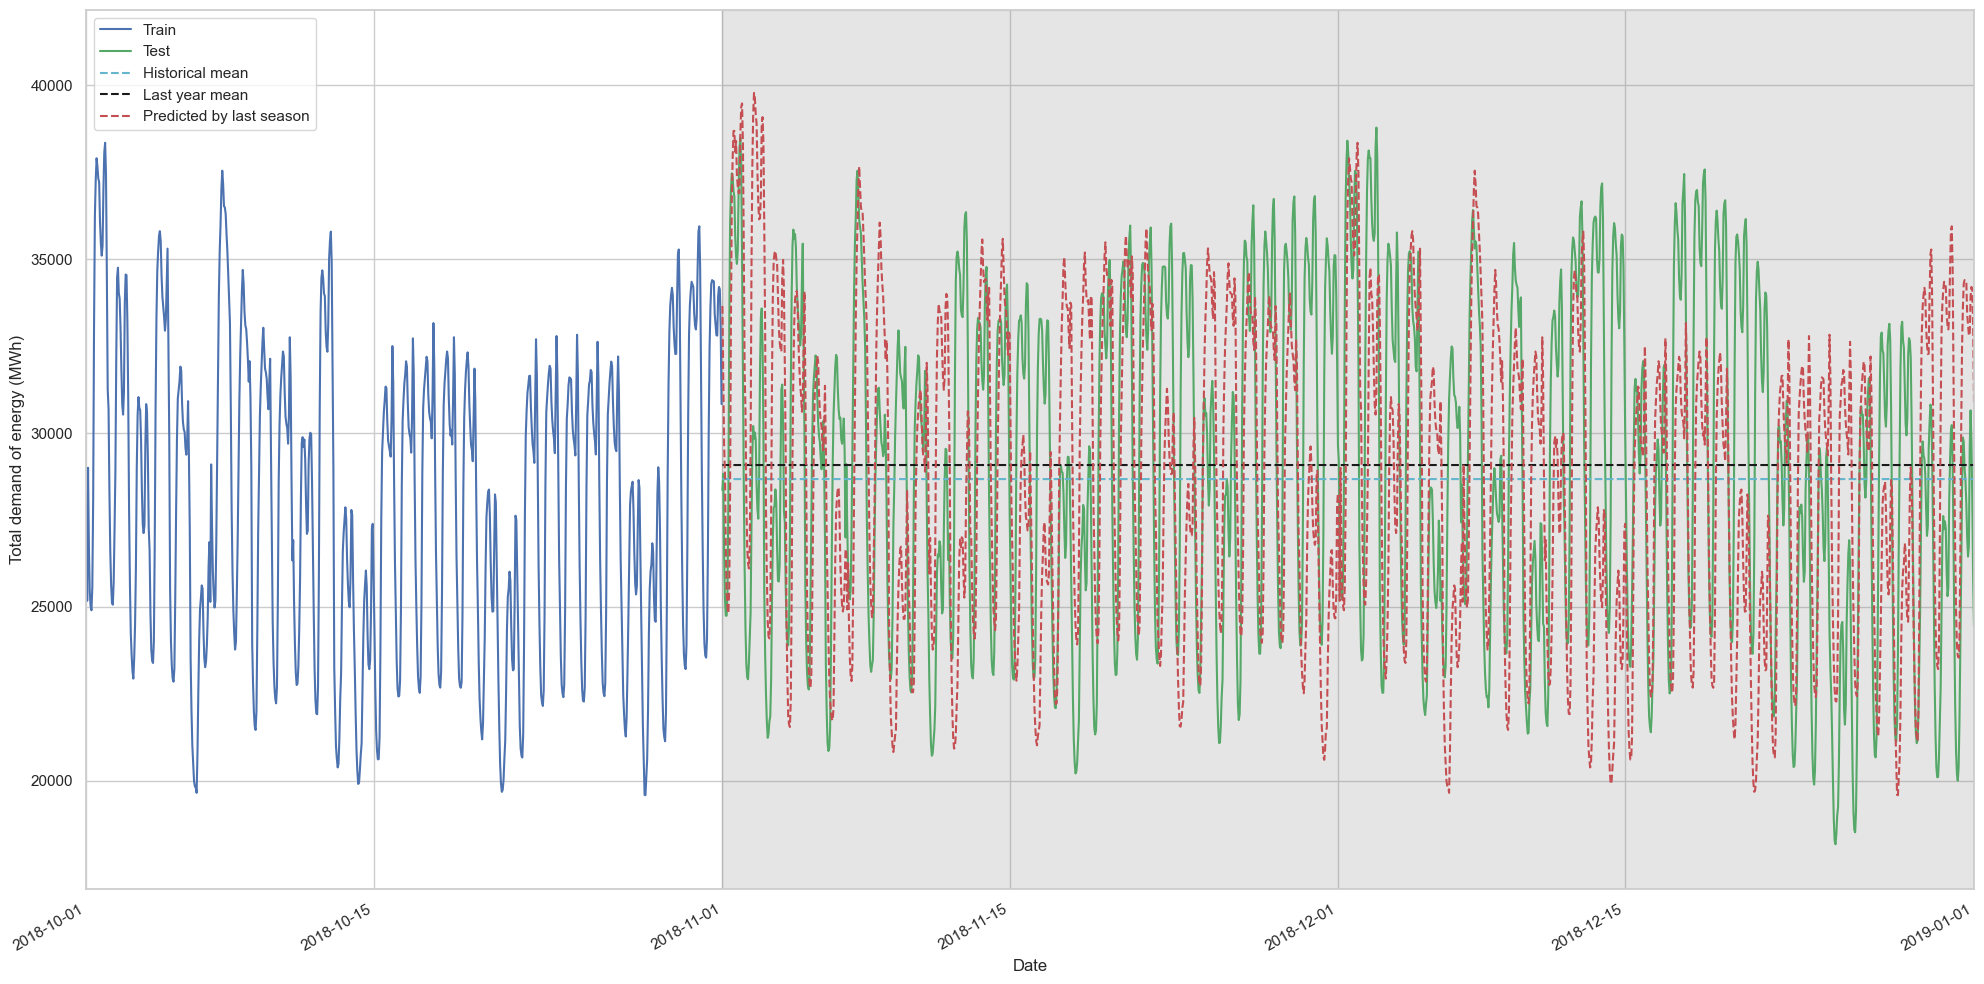

In [54]:
#Ploting our baselines in a graph
sns.set(rc={"figure.figsize":(20,10)})
sns.set_style('whitegrid')
fig, ax = plt.subplots()

ax.plot(training.index, training['total load actual'], 'b', label='Train')
ax.plot(testing.index, testing['total load actual'], 'g-', label='Test')
ax.plot(testing.index, testing['historicalmean'], 'c--', label='Historical mean')
ax.plot(testing.index, testing['last_year_mean'], 'k--', label='Last year mean')
ax.plot(testing.index, testing['Naive_seasonal'], 'r--', label='Predicted by last season')

x_start = pd.to_datetime('2018-10-01 00:00:00')
x_end = pd.to_datetime('2019-01-01 00:00:00')
ax.set_xlim(x_start, x_end)


ax.set_xlabel('Date')
ax.set_ylabel('Total demand of energy (MWh)')
ax.axvspan('2018-11-01 00:00:00', '2019-01-01 00:00:00', color='#808080', alpha=0.2)
ax.legend(loc=2)

fig.autofmt_xdate()
plt.tight_layout()

### 4.2.4- Calculating the Mean Absolut Percentage Error (MAPE)

It will be used in this project the Mean absolut percentage error to calculate the efficiency of the baselines defined. To calculate the MAPE, we subtract our prediction from the actual value, and divide by the actual value, point by point, and afterwards calculate the mean of all the values calculated. To perform the method we will define a function.

In [55]:
# Method to calculate the predicted percentage of the dataframe
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [56]:
#Calculating MAPE to historical mean
mape_hist_mean = mape(testing['total load actual'], testing['historicalmean'])
print(mape_hist_mean)

14.640502627091387


In [57]:
#Calculating MAPE to last year mean
mape_last_year_mean = mape(testing['total load actual'], testing['last_year_mean'])
print(mape_last_year_mean)

14.755042012066793


In [58]:
#Calculating MAPE to Naive Seasonal
mape_naive_seasonal = mape(testing['total load actual'], testing['Naive_seasonal'])
print(mape_naive_seasonal)

13.906236461615212


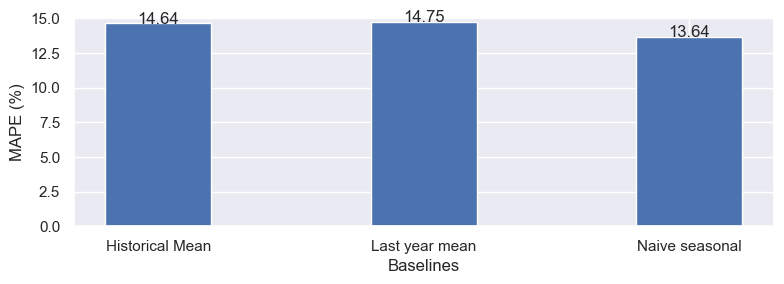

In [59]:
#Printing the baselines found graphically

sns.set(rc={"figure.figsize":(8,3)})
fig, ax = plt.subplots()

x = ['Historical Mean', 'Last year mean', 'Naive seasonal']
y = [14.64, 14.75, 13.64]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Baselines')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value, s=str(value), ha='center')

plt.tight_layout()

As we can see, our baselines are not very accurate, and they cannot be used as models to predict energy, once they present error over 10%, what is an enormous values given the important of energy production and distribution. As it follows, we will try to tackle the problem using some different models.

## 4.3- Applying  Exponential Smoothing

### 4.3.1- Applying Simple Exponential Smoothing

In [60]:
#Defining the number of periods and the level alpha
m = 24
alpha = 1/(m * 2)

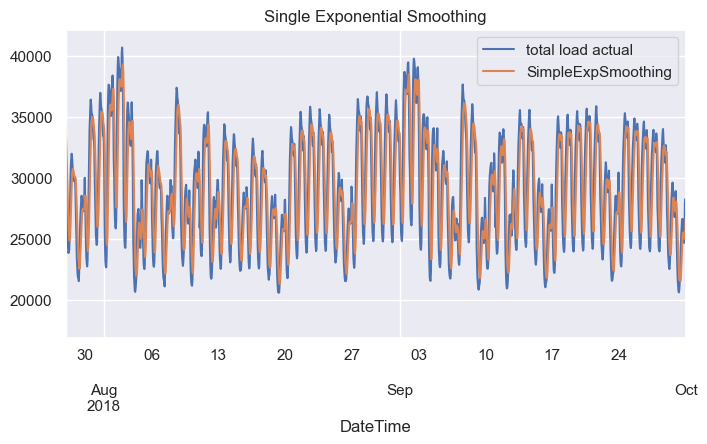

In [61]:
#Fitting the model and plotting it against the original dataset
training['SimpleExpSmoothing'] = SimpleExpSmoothing(training['total load actual']).fit(
                                                    smoothing_level = 0.3, optimized = False, use_brute = True).fittedvalues
# plot the values of 'total load actual' and 'HWES1'
training[['total load actual','SimpleExpSmoothing']].plot(title = 'Single Exponential Smoothing', figsize = (8,4));
plt.xlim('2018-07-28 00:00:00', '2018-10-01 00:00:00');


In [62]:
# Fitting the model and analysing the metrics

SimpleExponential_model = SimpleExpSmoothing(training['total load actual']).fit(
                                             smoothing_level = alpha, 
                                             optimized = False, 
                                             use_brute = True)

SimpleExponential_predictions = SimpleExponential_model.forecast(1465)

print('Mean Absolute Error: (MAE)', mean_absolute_error(testing['total load actual'], SimpleExponential_predictions))
print('Mean Squared Error: (MSE)', mean_squared_error(testing['total load actual'], SimpleExponential_predictions))
print('R Squared Score:', r2_score(testing['total load actual'], SimpleExponential_predictions))

Mean Absolute Error: (MAE) 4118.794791667766
Mean Squared Error: (MSE) 23097559.01117332
R Squared Score: -0.02476305500984677


It is possible to verify that the metrics for the method are not satisfactory, and therefore it will be discarded.

### 4.3.2- Double HWES

In [63]:
# Call a method for double ExponentialSmoothing and saving fitted  values in the training dataset.
training['HWES2_ADD'] = HWES(training['total load actual'], trend = 'add').fit().fittedvalues
training['HWES2_MUL'] = HWES(training['total load actual'], trend = 'mul').fit().fittedvalues

(20000.0, 40000.0)

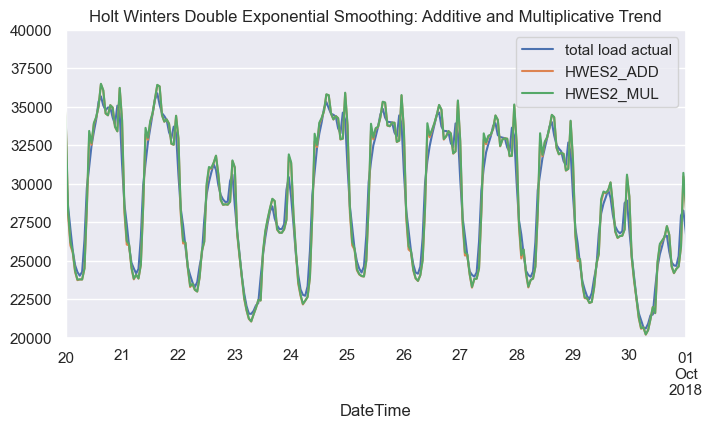

In [64]:
# Plotting a window of the dataframe mentioned to verify how close the values approach to in-sample predicition
training[['total load actual', 'HWES2_ADD', 'HWES2_MUL']].plot(
                                        title = 'Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend',figsize = (8,4))

plt.xlim('2018-09-20 00:00:00', '2018-10-01 00:00:00');
plt.ylim(20000,40000)

In [65]:
# Fitting the model and analysing the metrics

DoubleHWES_model = HWES(training['total load actual'], trend = 'mul').fit()
DoubleHWES_predictions = DoubleHWES_model.forecast(1465)

print('Mean Absolute Error: (MAE)', mean_absolute_error(testing['total load actual'], DoubleHWES_predictions))
print('Mean Squared Error: (MSE)', mean_squared_error(testing['total load actual'], DoubleHWES_predictions))
print('R Squared Score:', r2_score(testing['total load actual'], DoubleHWES_predictions))

Mean Absolute Error: (MAE) 28885.306229030095
Mean Squared Error: (MSE) 860547283.3903159
R Squared Score: -37.179664902290796


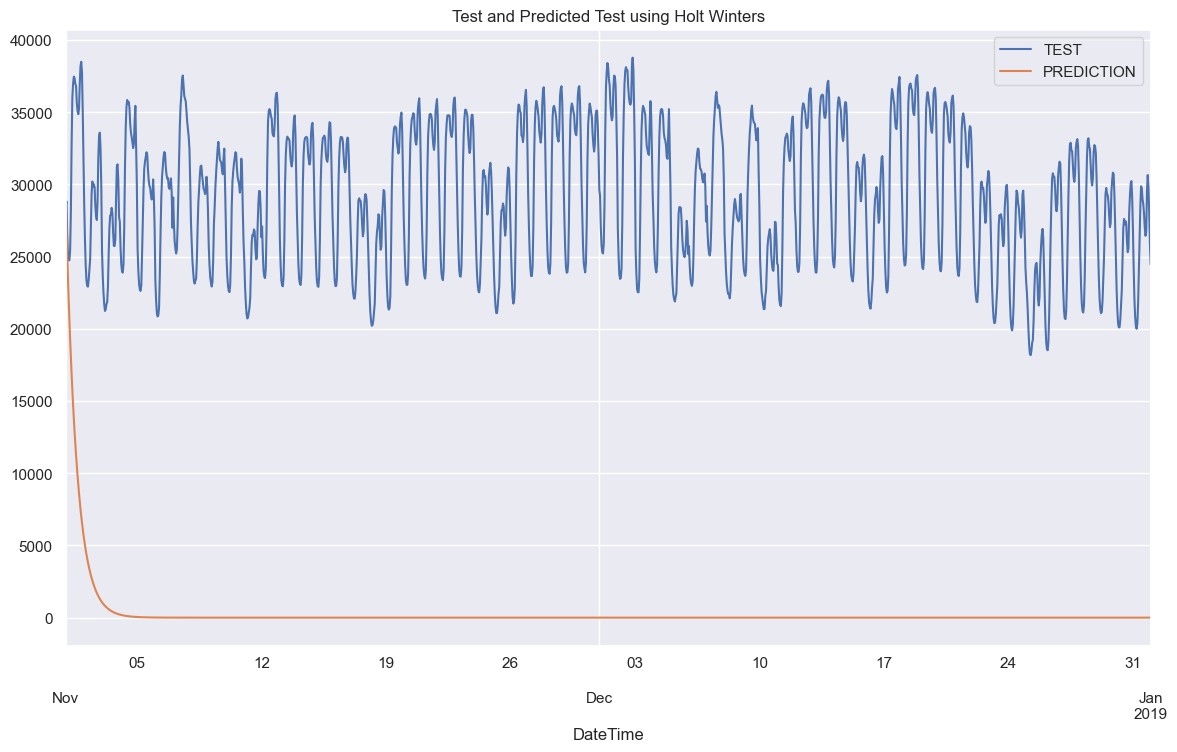

In [66]:
testing['total load actual'].plot(legend = True, label = 'TEST', figsize = (14, 8))
DoubleHWES_predictions.plot(legend = True, label = 'PREDICTION')

# Display the title of the figure
plt.title('Test and Predicted Test using Holt Winters');

It is possible to verify that although the model seems to predict values in sample very well, the model looses the capacity to generalize, and therefore it cannot create predictions to values that has never been seen before, converging quickly to 0. That is a characteristic of overfitting models, and hence the model will be discarded.

### 4.3.3- Triple HWES

In [67]:
# Include the trend and season for two different cases such as 'add' and 'mul'
training['HWES3_ADD'] = HWES(training['total load actual'], 
                                               trend = 'add', seasonal = 'add', seasonal_periods = 24).fit().fittedvalues

training['HWES3_MUL'] = HWES(training['total load actual'], 
                                               trend = 'mul', seasonal = 'mul', seasonal_periods = 24).fit().fittedvalues


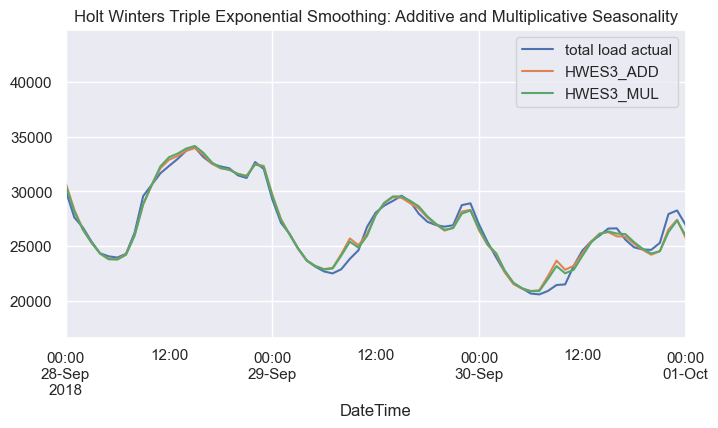

In [68]:
# plot the dataset for three columns, 'total load actual','HWES3_ADD','HWES3_MUL'
training[['total load actual','HWES3_ADD','HWES3_MUL']].plot(
                                  title = 'Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality', figsize = (8,4));

#Including a limit on x-axis to see the graphs closer
plt.xlim('2018-09-28 00:00:00', '2018-10-01 00:00:00');

### 4.3.4- Predicting with Holt-Winter Exponencial Smoothing

In [69]:
#Fitting the model using multiplicative trend and seasonality

TripleHWSE_model = HWES(training['total load actual'], 

                        trend = 'add', seasonal = 'mul', seasonal_periods = 24).fit()

In [70]:
#Getting the forecast on the window expect.

TripleHWSE_predictions = TripleHWSE_model.forecast(1465)

Text(0.5, 1.0, 'Test and Predicted Test using Holt Winters')

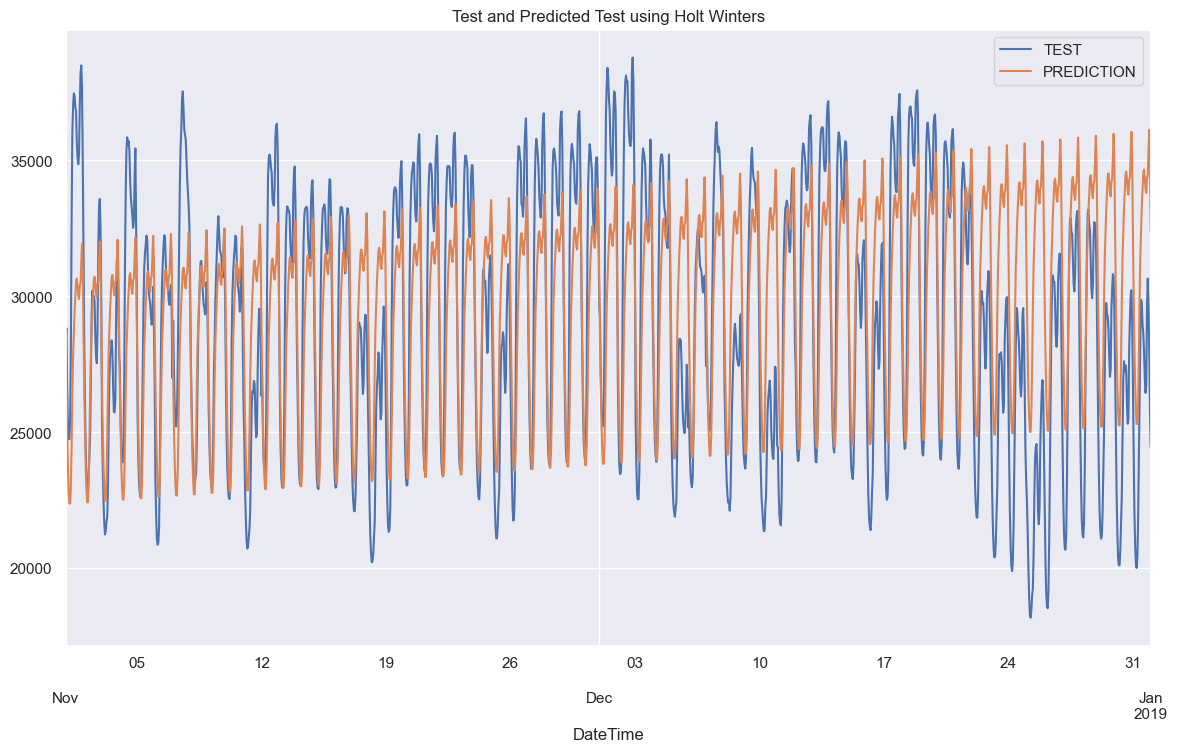

In [71]:
#Plotting predicted data against the original data.
testing['total load actual'].plot(legend = True, label = 'TEST', figsize = (14, 8))
TripleHWSE_predictions.plot(legend = True, label = 'PREDICTION')

# Display the title of the figure
plt.title('Test and Predicted Test using Holt Winters')

In [72]:
#Printing the metrics for the method

print('Mean Absolute Error: (MAE)', mean_absolute_error(testing['total load actual'], TripleHWSE_predictions))
print('Mean Squared Error: (MSE)', mean_squared_error(testing['total load actual'], TripleHWSE_predictions))
print('R Squared Score:', r2_score(testing['total load actual'], TripleHWSE_predictions))

Mean Absolute Error: (MAE) 2916.9272504687915
Mean Squared Error: (MSE) 13079513.549383383
R Squared Score: 0.41970481571559237


It is interesting to observe that, although we got significant improvement in our model comparing to Simple Exponencial Smoothing, when compared R Squared, our model rather explodes increasing constantly along the interval selected, than predicts the data precisely. In the windows we are observing, the model might perform somewhat reasonably, but we can not consider that the model could be generalized to longer forecasts.

Let us verify the value for MAPE that we can get with the model.

In [73]:
mape_holt_winters = mape(testing['total load actual'], TripleHWSE_predictions)
print(mape_holt_winters)

10.331850662727218


The MAPE shows small improvement compared to our baselines, around 3% compared with Naive Seasonal. However, the fact that the model explodes could lead to worst results compared with our baseline in case the window of prediction was longer.

## 4.4- Predicting through Unobserved Components

The method of Unobserved Components was performed by (TOTH, 2021) achieving consistent results in a dataset with similar properties of the one is being treated in this project, and therefore, we will use the same method to analyse how well it performs in our case. The model will be applied as it follows. All the parameters used to create the model were presented by (TOTH, 2021), however, the values chosen for each one of them were found by multiple attempts, observing and trying to increase the value of R squared.

In [74]:
#Unobserved Components model definition
model_UC1 = sm.tsa.UnobservedComponents(training['total load actual'],
                                        trend=True,
                                        level=False,
                                        irregular=False,
                                        stochastic_level = False,
                                        stochastic_trend = False,
                                        stochastic_freq_seasonal = [False, False, False],
                                        freq_seasonal=[{'period': 24, 'harmonics': 3},
                                                       {'period': 168, 'harmonics': 2},
                                                       {'period': 8766, 'harmonics': 1}])
#fitting model to train data
model_UC1res = model_UC1.fit()

#printing statsmodels summary for model
print(model_UC1res.summary())


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.43292D+00    |proj g|=  5.82723D-05


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      7      1     0     0   3.954D-06   9.422D+00
  F =   9.4223395778546291     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                           Unobserved Components Results                            
Dep. Variable:            total load actual   No. Observations:                33599
Model:                  deterministic trend   Log Likelihood             -316581.187
                     + freq_seasonal(24(3))   AIC                         633164.375
                    + freq_seasonal(168(2))   BIC                         633172.79

In [75]:
#model forecast
forecast_UC1 = model_UC1res.get_forecast(steps=1465)
forecast_UC1res = model_UC1res.forecast(steps=1465)
forecast_ci_UC1 = forecast_UC1.conf_int()

In [76]:
print('Mean Absolute Error: (MAE)', mean_absolute_error(testing['total load actual'], forecast_UC1res))
print('Mean Square Error: (MSE)', mean_squared_error(testing['total load actual'], forecast_UC1res))
print('R Squared Score:', r2_score(testing['total load actual'], forecast_UC1res))

Mean Absolute Error: (MAE) 2324.0530623215113
Mean Square Error: (MSE) 9064405.040911071
R Squared Score: 0.5978420318321409


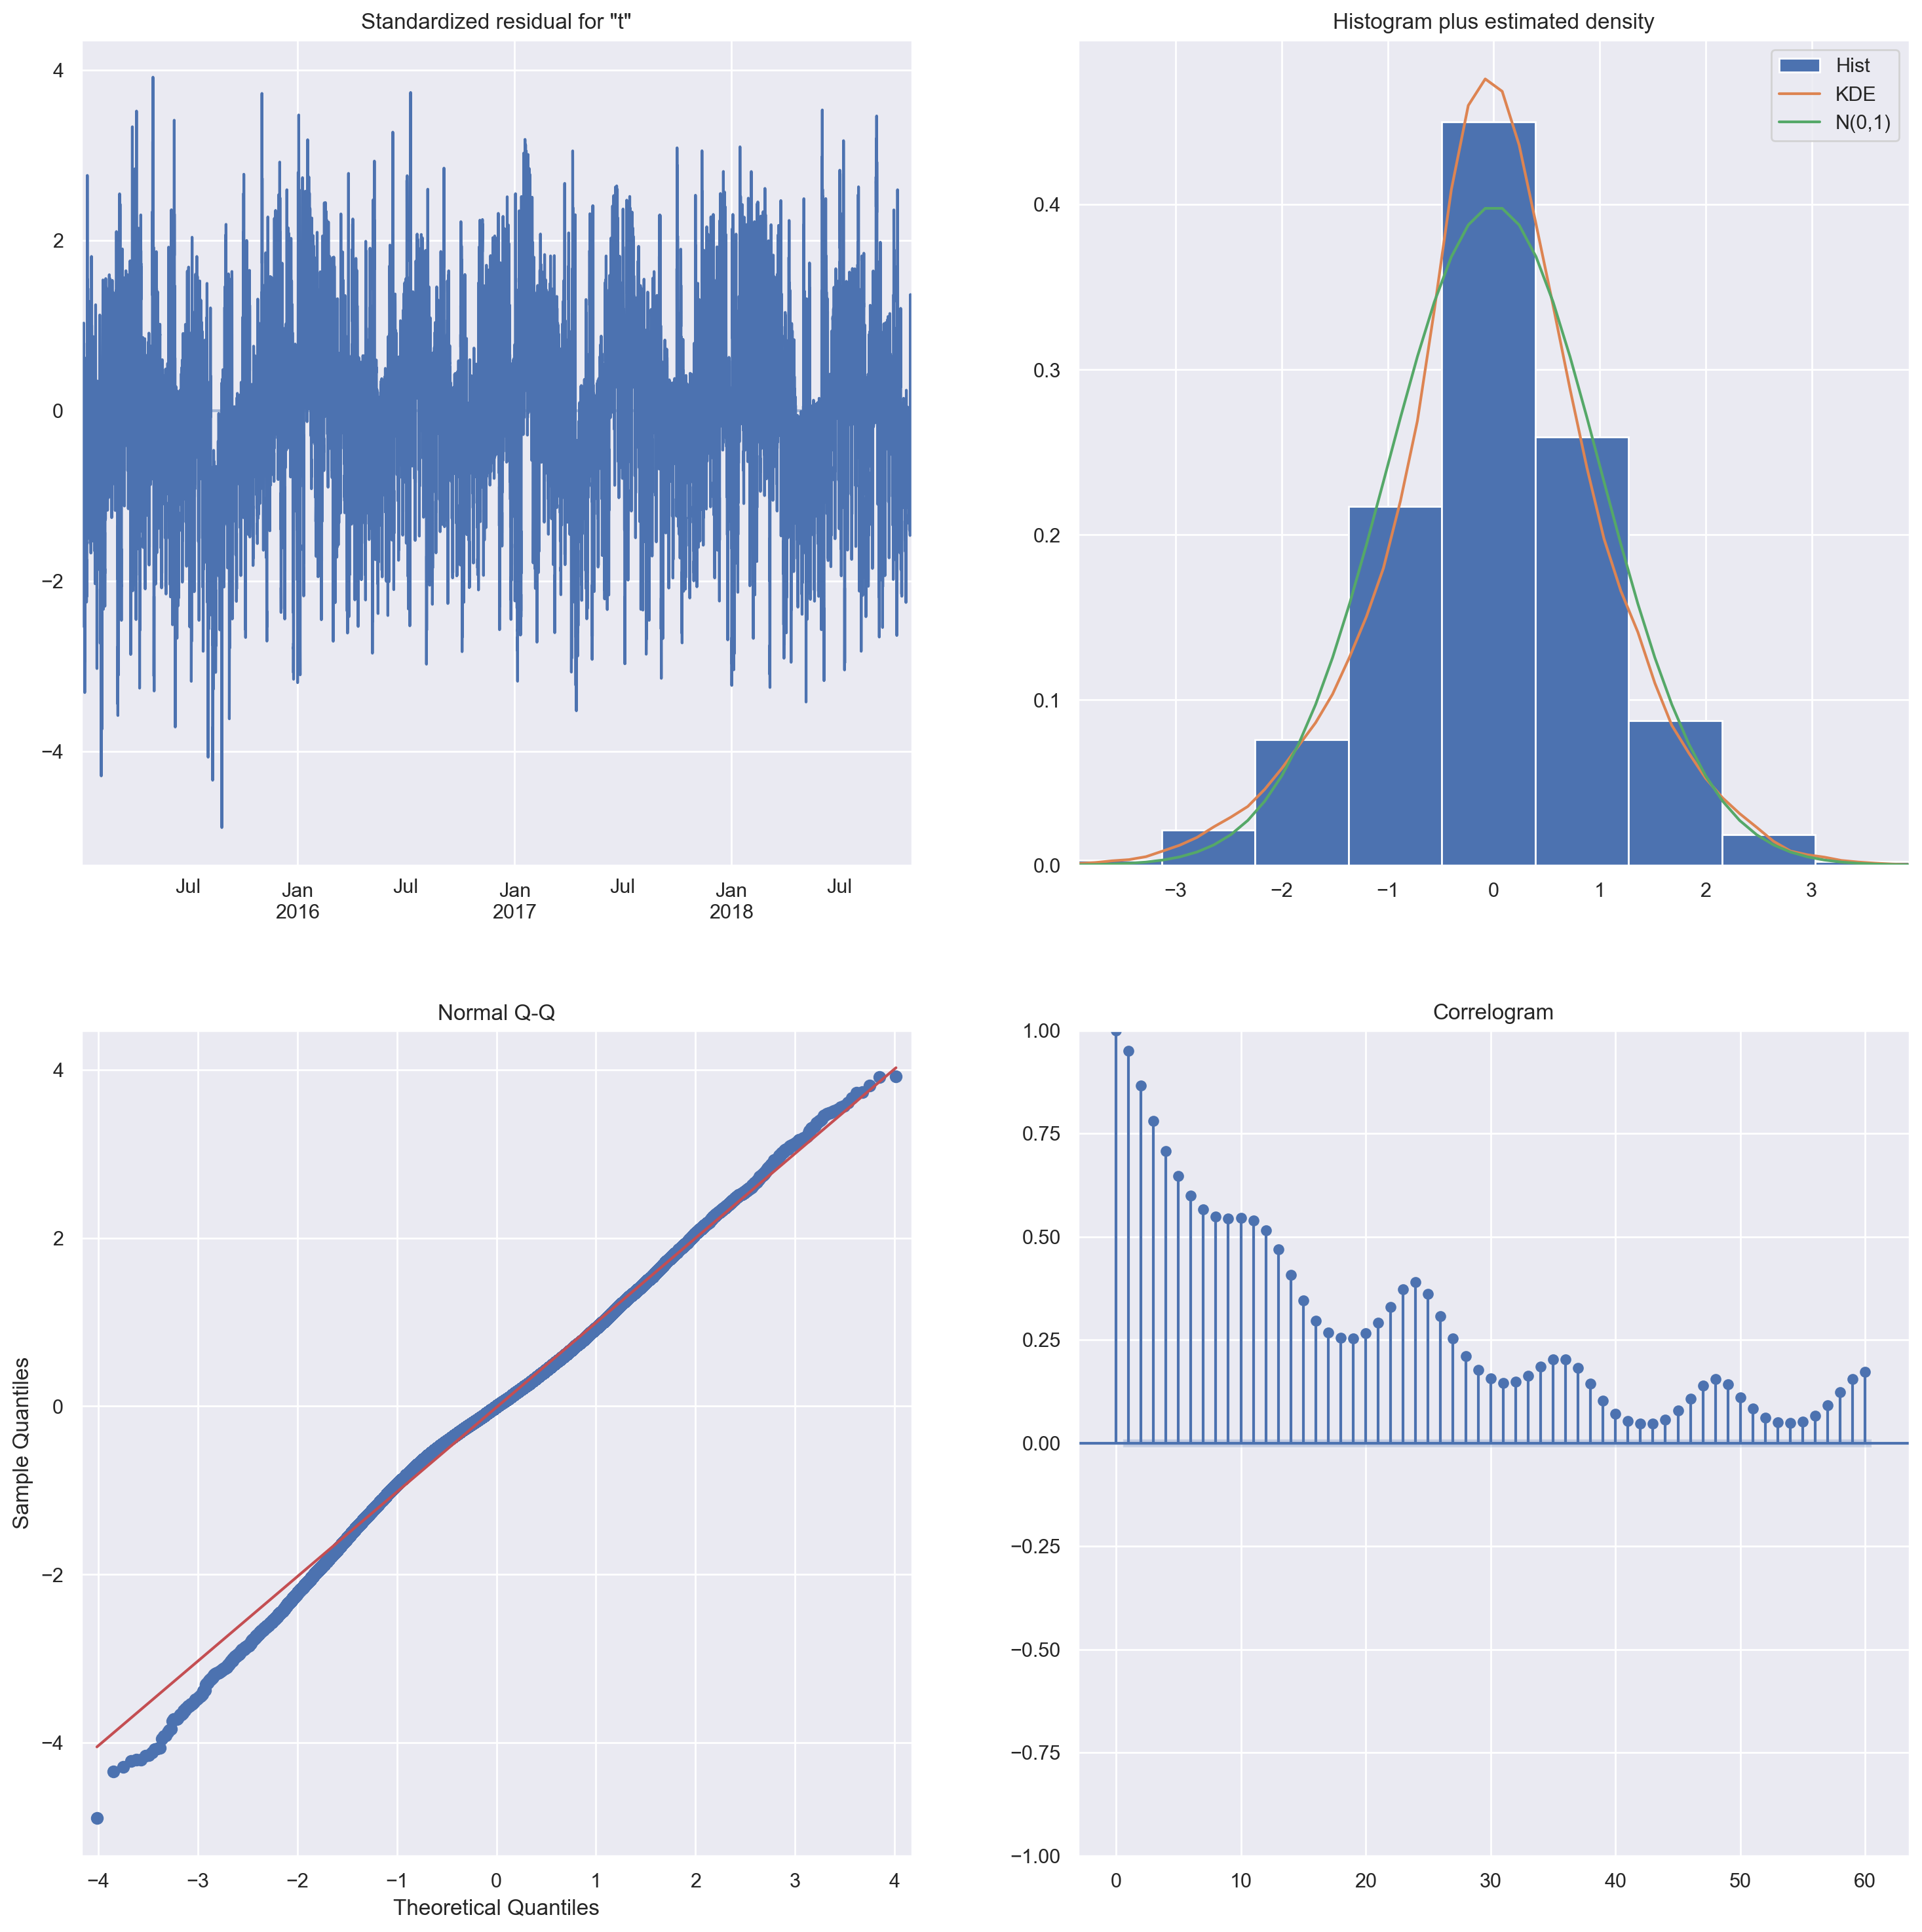

In [77]:
#plotting residual diagnostics of Unobserved Components model
model_UC1res.plot_diagnostics(figsize=(18,18),lags=60).set_dpi(200);
plt.show();

In [78]:
mape_unobserved_comp = mape(testing['total load actual'], forecast_UC1res)
print(mape_unobserved_comp)

8.08647276421609


Text(0.5, 1.0, 'Test and Predicted Test using Unobserved Components method')

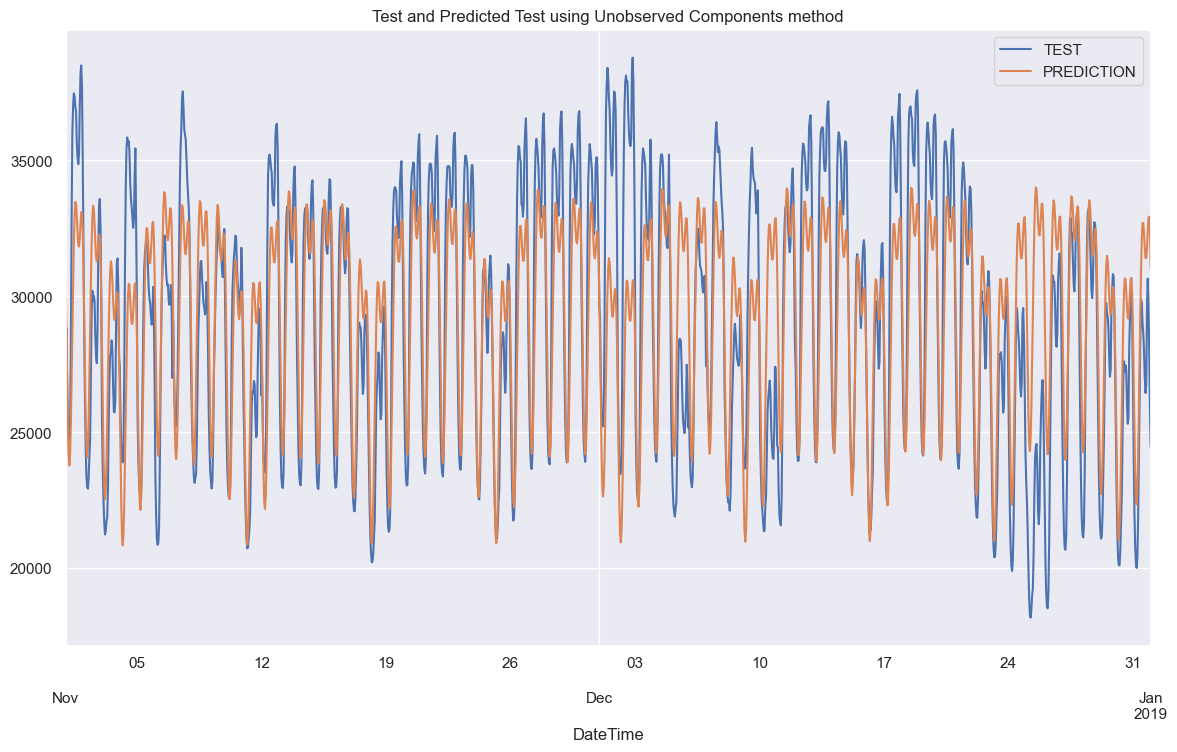

In [79]:
#Plotting predicted data against the original data.
testing['total load actual'].plot(legend = True, label = 'TEST', figsize = (14, 8))
forecast_UC1res.plot(legend = True, label = 'PREDICTION')

# Display the title of the figure
plt.title('Test and Predicted Test using Unobserved Components method')

As we can verify from our indicators and graphs, we could reach a much better result when using the method suggested. We could reach the highest value of R squared, reaching slightly less than 60%. MAPE has been reduced by another 2% compared to Holt-Winters, and around 5% compared with our best performing baseline. When we observe our results through its diagnosis, we can verify:

1- Aparently there is still a seasonality in our residuals, what is not ideal to the model, and might be responsible for our still far from ideal performance. However, that might be caused by external factors that we cannot predict, such as temperature and other weather variables.

2- Distribution of the residuals if fairly normal, what is a positive point of the model.

3- The Q-Q graph shows the blue spots distributed closely to the red line that represents an ideal normal distribution, deviating maily on the beginning, what is another sign that the residuals are normaly distributed.

4- The correlogram tends to 0, but it still shows a high correlation with lagged values on the residuals, what might again because by external factors.

Below it will be plotted the decomposition of the serie just created with the model, showing the trending, seasonal, and residual components.

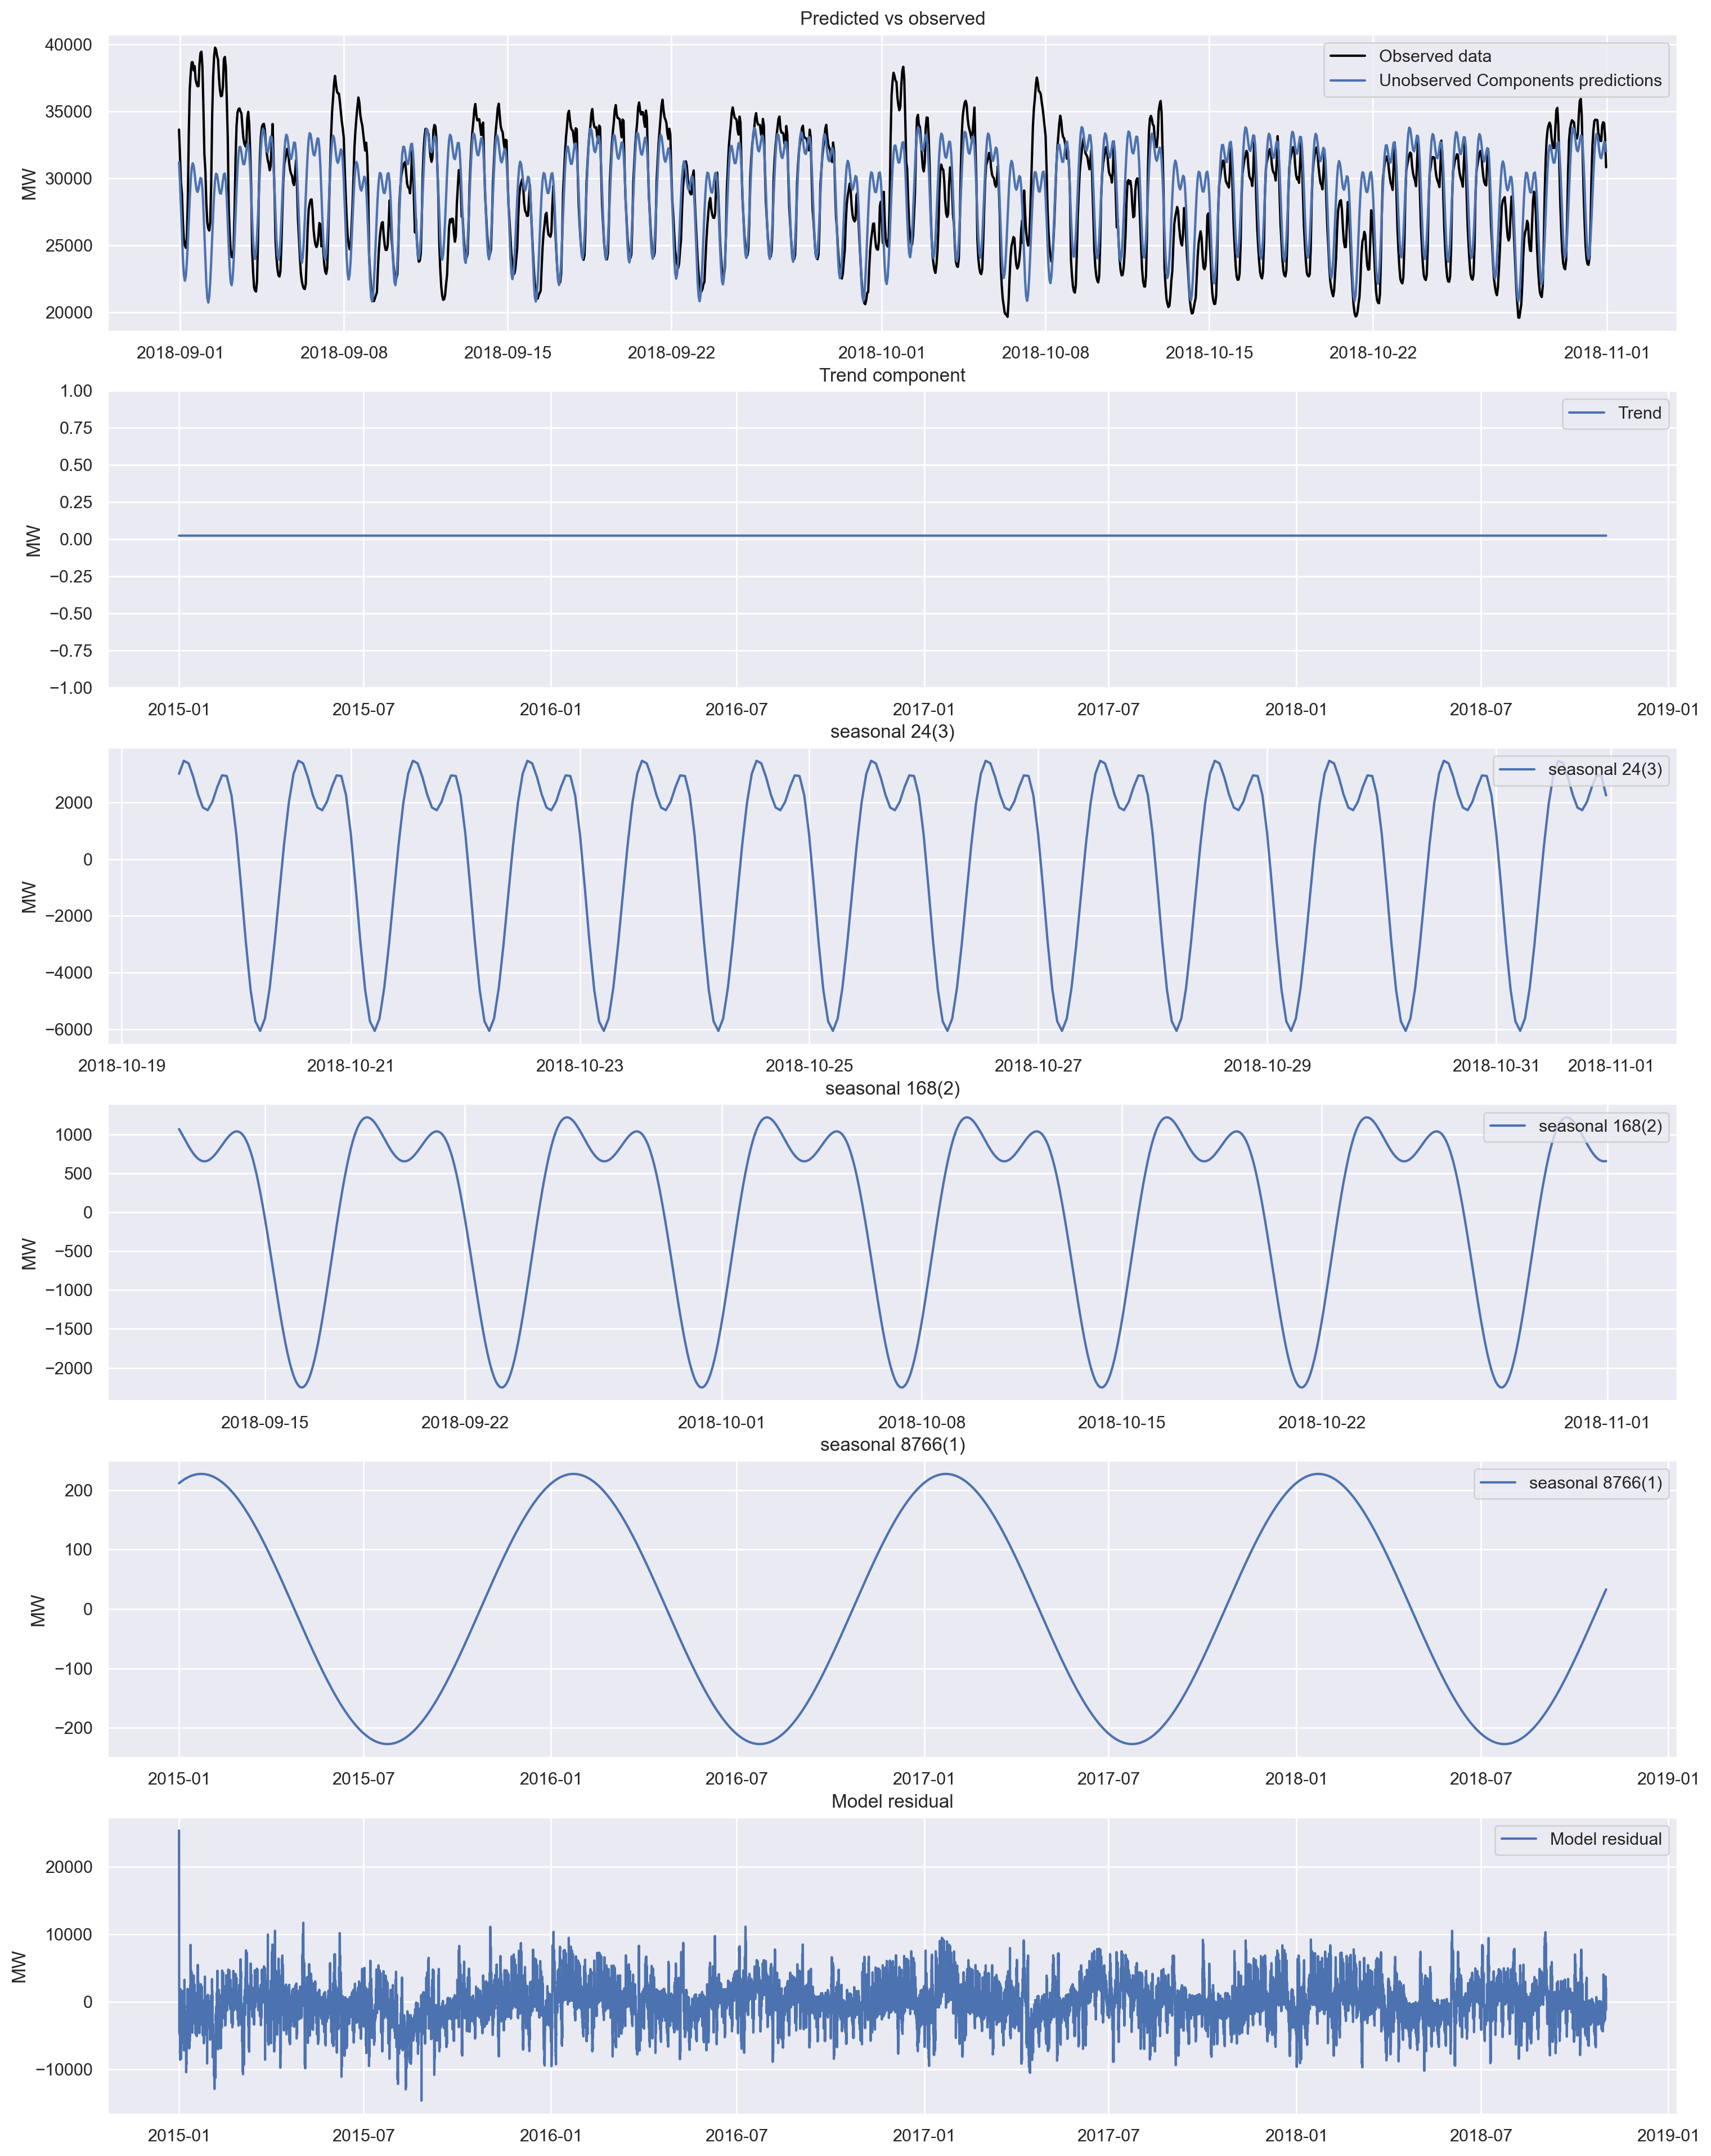

In [80]:
f, axes = plt.subplots(6,1,figsize=(18,24),dpi=200)

#custom plotting of observed train data in style of results class '.plot_components()' method

#plotting observed data vs. in-sample prediction
axes[0].plot(training.iloc[-1465:, 0], label='Observed data', color='black');
axes[0].plot(model_UC1res.fittedvalues[-1465:], label='Unobserved Components predictions');
axes[0].legend()

#plotting smoothed level component
#axes[1].plot(training.index, model_UC1res.level['smoothed'], label='Level');
#axes[1].legend();

#plotting smoothed trend component
axes[1].plot(training.index, model_UC1res.trend['smoothed'], label='Trend');
axes[1].set_ylim(-1,1)
axes[1].legend();

limits = [-300, -1200, 0]

#plotting smoothed seasonal components with arbitrary time window scales
for i in range(2,5,1):
    axes[i].plot(training.index[limits[i-2]:], model_UC1res.freq_seasonal[i-2]['smoothed'][limits[i-2]:], label=model_UC1res.freq_seasonal[i-2]['pretty_name']);
    axes[i].legend(loc='upper right');

#plotting residuals
axes[5].plot(training.index, model_UC1res.resid, label='Model residual');
axes[5].legend();

#list of subplot titles
axtitles = ['Predicted vs observed',
            'Trend component',
            model_UC1res.freq_seasonal[0]['pretty_name'],
            model_UC1res.freq_seasonal[1]['pretty_name'],
            model_UC1res.freq_seasonal[2]['pretty_name'],
            'Model residual']

#setting y labels and subplot titles (former is missing from '.plot_components()')
for i,a in enumerate(axes):
    a.set_ylabel('MW')
    a.set_title(axtitles[i])

plt.show();

## 4.5- Predicting though SARIMA

Although it is known that SARIMA does not handle well multiple seasonality, we will try to forecast energy taking into consideration that the most important seasonality on the dataset is the daily one, and trying to fit the model only diferencing on this seasonality. The method SARIMA is composed by two components of the lag order, two component for the degree of differencing, and two component for the moving average window, one for the seasonal component of our dataset and one for the non-sealsonal component.

It will be applied first the Augmented Dickey Fuller test to verify the necessity of differencing our data. The test is a hypothesis test that takes the null hypothesis of non-stationarity of the data. Therefore, if p-value is higher than the treshold, that will be defined as 5%, we fail to reject the null hypothesis, and the data is non-stationary. If p-value is lower than the treshold, we reject the null hypothesis, hence the data in stationary.

The test will be applied below.


In [81]:
#Perfoming Augmented Dicky Fuller Test
ad_fuller_result = adfuller(df1['total load actual'])

In [82]:
#Printing all the results of the test.
print(ad_fuller_result)

(-21.701366778990288, 0.0, 52, 35011, {'1%': -3.43053679213716, '5%': -2.8616225575095284, '10%': -2.566813942767471}, 563662.7061862494)


In [83]:
# Display the outcomes of Dicky Fuller test
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -21.701366778990288
p-value: 0.0


As we can verify, p-value < 0.05, therefore we reject the null hypothesis, and our data should be considered stationary.

As we have 6 parameters to discover on our SARIMA model, we will first verify the parameters to ARIMA model, and than in the sequence we will try to verify the remaining three to SARIMA.


In [84]:
aicVal=[]
for d in range(1,3):
    for ari in range(0, 3):
        for maj in range(0,3):
            try:
                arima_obj = ARIMA(df1['total load actual'].tolist(), order=(ari,d,maj))
                arima_obj_fit=arima_obj.fit()
                aicVal.append([ari, d, maj, arima_obj_fit.aic])
            except ValueError:
                pass
print(aicVal)

[[0, 1, 0, 609797.9939073379], [0, 1, 1, 593673.0885364002], [0, 1, 2, 589234.2532689325], [1, 1, 0, 588268.522787743], [1, 1, 1, 587735.112256179], [1, 1, 2, 587555.7633461403], [2, 1, 0, 587568.7698907919], [2, 1, 1, 583057.8444057746], [2, 1, 2, 583057.0871907509], [0, 2, 0, 594280.9786252663], [0, 2, 1, 594208.3056387977], [0, 2, 2, 593900.0791996022], [1, 2, 0, 594220.2159219974], [1, 2, 1, 588158.2430051655], [1, 2, 2, 587621.9893895506], [2, 2, 0, 594006.577859355], [2, 2, 1, 587455.4855124742], [2, 2, 2, 582938.5727899147]]


We can verify that the best order for ARIMA in our dataset is 2,2,2. As it follow, it will be tried to to fit a SARIMA model with differencing seasonality on lag 24.

In [85]:
#Fitting SARIMA model in our data

SARIMA_model = SARIMAX(training['total load actual'], order = (2, 2, 2), seasonal_order = (2, 1, 0, 24), maxiter=5).fit(dis = -1)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.37743D+00    |proj g|=  3.89370D-01

At iterate    5    f=  8.19040D+00    |proj g|=  2.39044D-02

At iterate   10    f=  8.17523D+00    |proj g|=  1.72100D-02

At iterate   15    f=  8.17337D+00    |proj g|=  1.84493D-03

At iterate   20    f=  8.17294D+00    |proj g|=  1.13466D-03

At iterate   25    f=  8.17061D+00    |proj g|=  1.11344D-02

At iterate   30    f=  8.16959D+00    |proj g|=  5.52628D-03

At iterate   35    f=  8.14896D+00    |proj g|=  9.78700D-02

At iterate   40    f=  8.14341D+00    |proj g|=  4.81590D-05

At iterate   45    f=  8.14339D+00    |proj g|=  5.56125D-03

At iterate   50    f=  8.13887D+00    |proj g|=  1.06908D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

NameError: name 'SARIMAX_model' is not defined

In [86]:
# Display the summary of the model
print(SARIMA_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                   total load actual   No. Observations:                33599
Model:             SARIMAX(2, 2, 2)x(2, 1, [], 24)   Log Likelihood             -273458.036
Date:                             Fri, 10 Nov 2023   AIC                         546930.073
Time:                                     02:13:04   BIC                         546989.023
Sample:                                 01-01-2015   HQIC                        546948.887
                                      - 10-31-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7373      0.002   -431.541      0.000      -0.741      -0.734
ar.L2          0.2377      

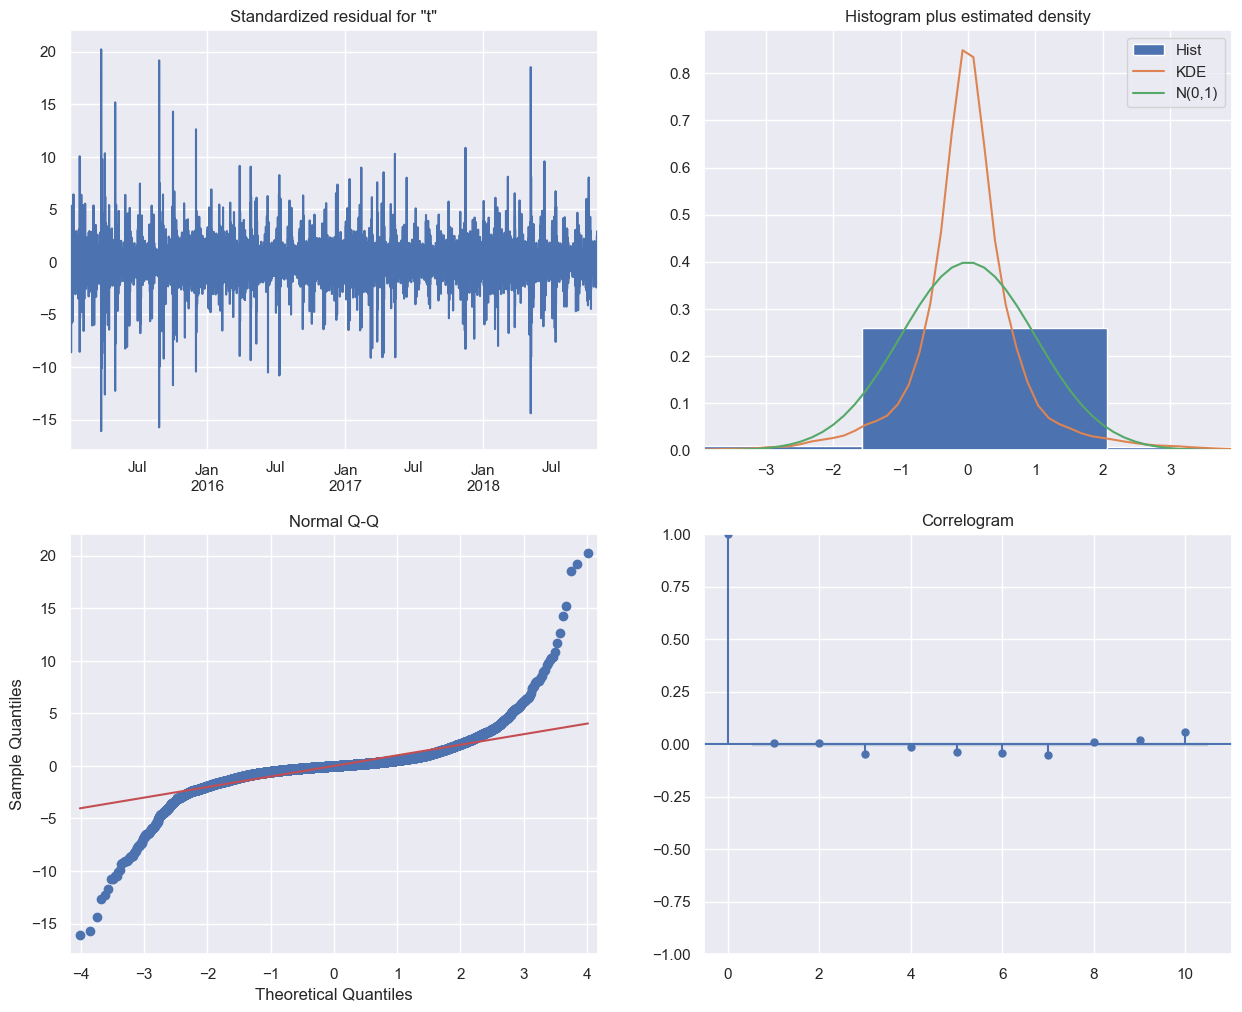

In [87]:
# Diagnosing the model residuals
SARIMA_model.plot_diagnostics(figsize = (15, 12))
plt.show()

In [88]:
forecast_values_SARIMA = SARIMA_model.get_forecast(steps = 1465)
forecast_ci_SARIMA = forecast_values_SARIMA.conf_int()
forecast_index = pd.date_range(start=df1.index[-1465], periods=1465, freq = 'H')

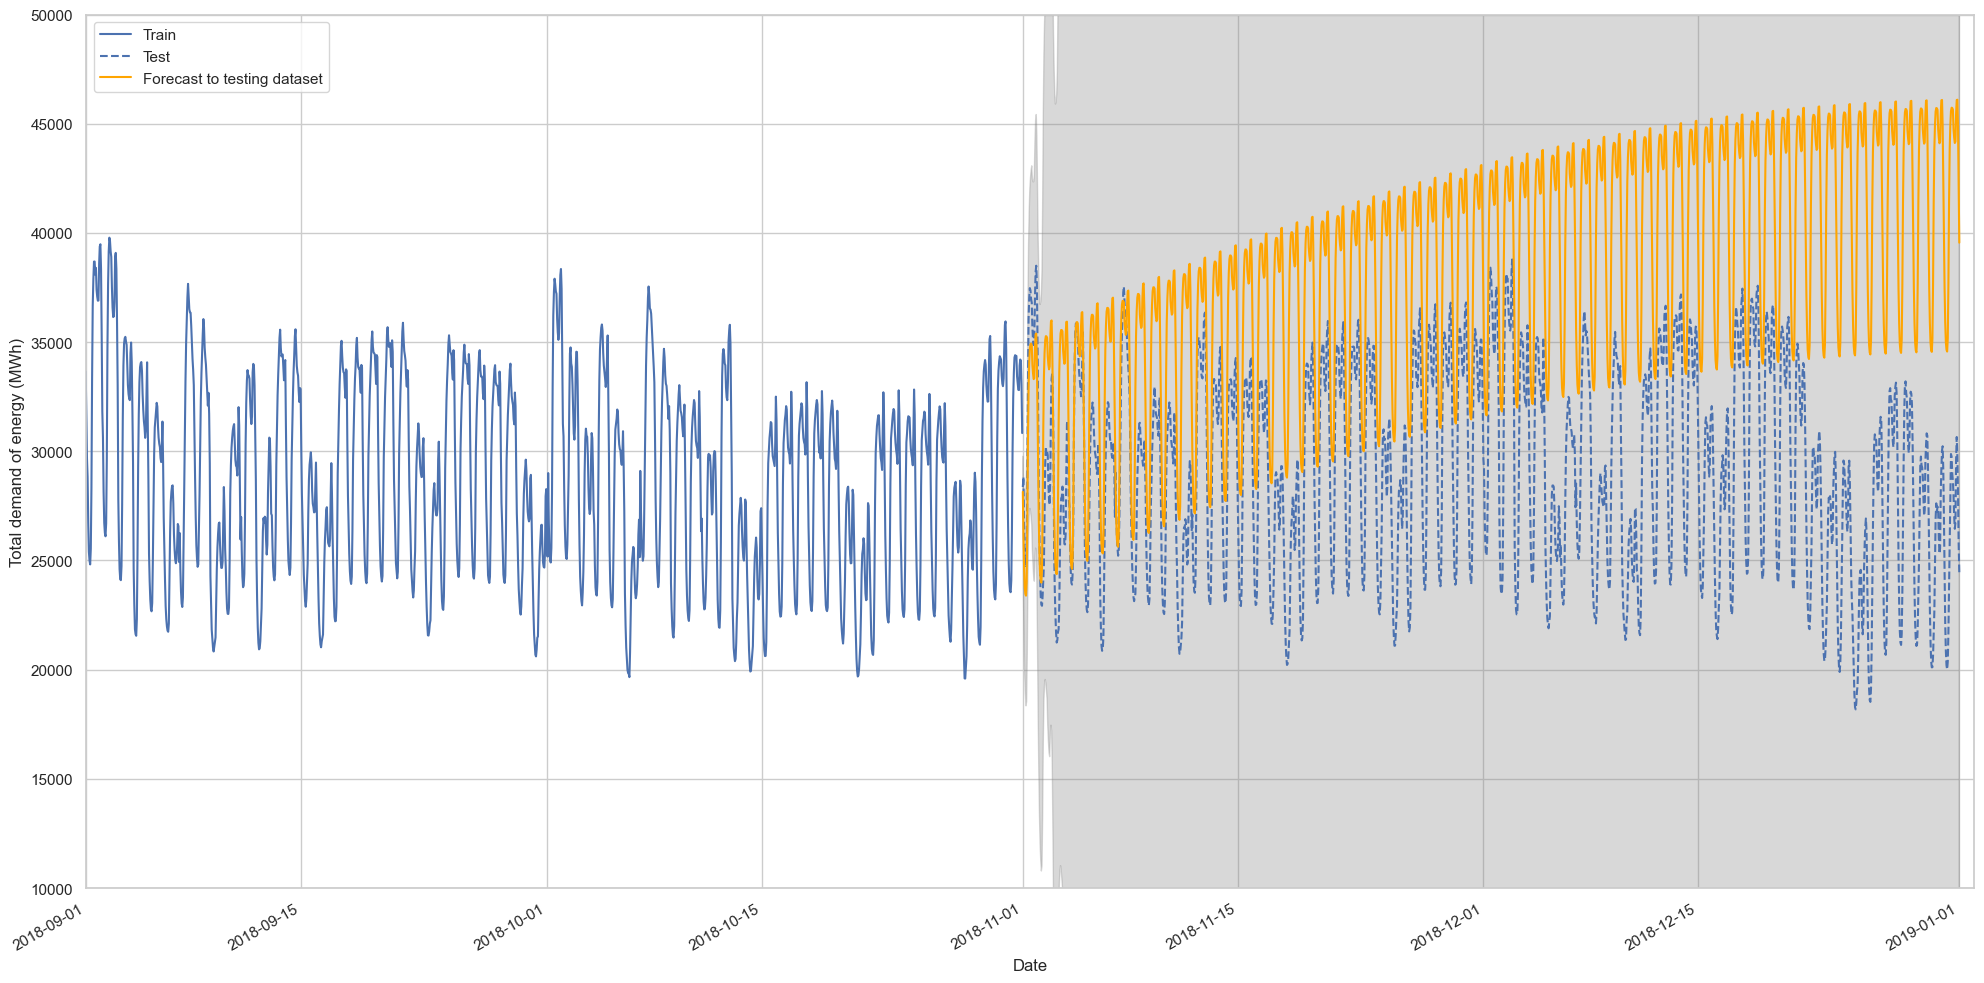

In [89]:
##Plotting our forecast in a graph

sns.set(rc={"figure.figsize":(20,10)})
sns.set_style('whitegrid')
fig, ax = plt.subplots()

ax.plot(training.index, training['total load actual'], 'b', label='Train')
ax.plot(testing.index, testing['total load actual'], 'b--', label='Test')
ax.plot(forecast_index, forecast_values_SARIMA.predicted_mean, 'orange', label = 'Forecast to testing dataset')

# Plot the confidence intervals
ax.fill_between(forecast_index,
                forecast_ci_SARIMA.iloc[:, 0],
                forecast_ci_SARIMA.iloc[:, 1], 
                color = 'grey', alpha = .3)

x_start = pd.to_datetime('2018-09-01 00:00:00')
x_end = pd.to_datetime('2019-01-01 23:00:00')
plt.xlim(x_start, x_end)
plt.ylim(10000, 50000)

ax.set_xlabel('Date')
ax.set_ylabel('Total demand of energy (MWh)')

ax.legend(loc=2)

fig.autofmt_xdate()
plt.tight_layout()

In [90]:
mape_SARIMA = mape(testing['total load actual'], forecast_values_SARIMA.predicted_mean)
print(mape_SARIMA)

32.719658023135956


In [91]:
print('Mean Absolute Error: (MAE)', mean_absolute_error(testing['total load actual'], forecast_values_SARIMA.predicted_mean))
print('Mean Square Error: (MSE)', mean_squared_error(testing['total load actual'], forecast_values_SARIMA.predicted_mean))
print('R Squared Score:', r2_score(testing['total load actual'], forecast_values_SARIMA.predicted_mean))

Mean Absolute Error: (MAE) 9030.174208343758
Mean Square Error: (MSE) 101904299.12653007
R Squared Score: -3.5211600429735395


As we can observe from the Method SARIMA, it did not perform well as it was already expected. From the plot of diagnosis, we can verify that all the indicators highly deviate from the ideal. The histogram do not show  a distribution even close to the idea, and que Q-Q chat highly deviates from the baseline. All the metrics used to analyse models show scores far away from ideal, and by comparing the MAPE is possible to verify that the model perform even much worse than our stablished baselines. 

It has been presented by (Pawar, 2020) the use of SARIMAX, using a decomposed version of the dataset as external variables, an use of the method with a fair accuracy, however, the same study highlights the computational cost of the method and its inneficiency. In our project, it took quite a long time to perform only one run of the method on the dataset. Furthermore, references show that the method is by far outperfomed by methods more specific to this application. Therefore, we will no longer explore it.

# 5- Comparing metrics on the methods

After fitting the models, we will briefly expose some metrics that are important to our models in comparative ways. Our best baseline before applying methods to get predictions to the next 2 months was 13.64% far from the real values, whereas our best model, fitted using a method names Unobserved Components, was 8.08%. 

We will plot bellow a graph containing all the results obtained of MAPE for each method.

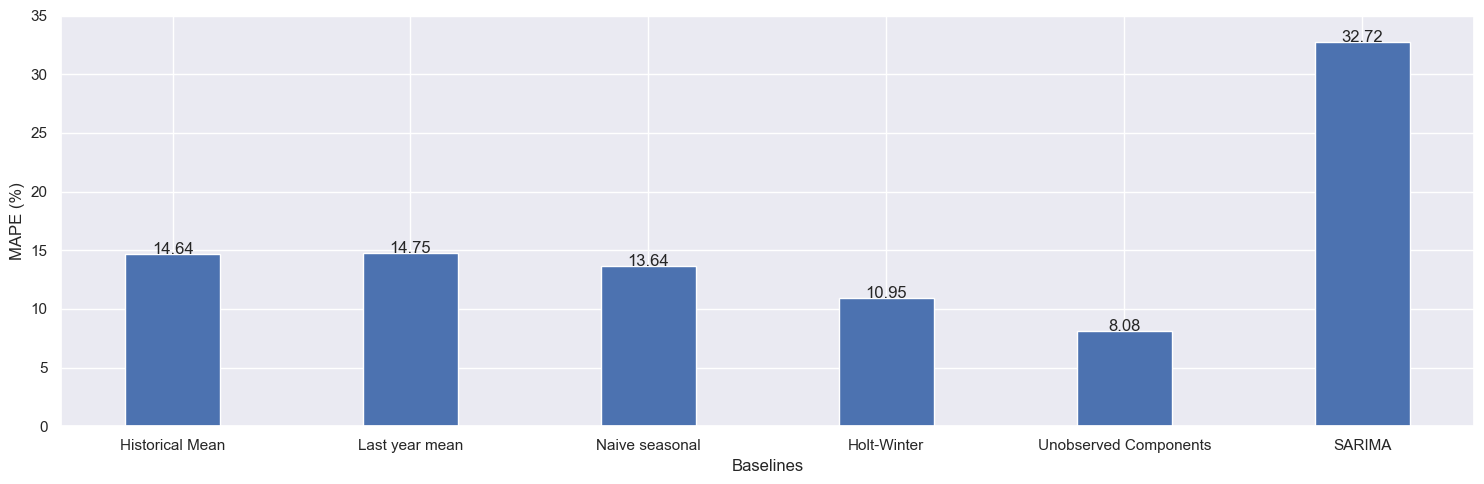

In [92]:
#Printing the baselines found graphically

sns.set(rc={"figure.figsize":(15,5)})
fig, ax = plt.subplots()

x = ['Historical Mean', 'Last year mean', 'Naive seasonal', 'Holt-Winter', 'Unobserved Components', 'SARIMA']
y = [14.64, 14.75, 13.64, 10.95, 8.08, 32.72]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Baselines')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 35)

for index, value in enumerate(y):
    plt.text(x=index, y=value, s=str(value), ha='center')

plt.tight_layout()

The method of Unobserved Components shows a very favourable result. Some advantages using the method during this project include the simplicity for application, low time for processing the whole method including the computational cost while running, and a very good result in a dataset with complex's seasonalities being treated in a simple way.

# 6- Conclusion

Forecasting electricity demand is a task that helps to prevent waste of energy and promotes a more smart use of electricity and the energy grid. At the same time, electricity forecast is an important output when planning projects to expansion of energy grids and prevents shortage of energy, which is a precious resource.

Although fine adjusts, and experimentation with other models are necessary to reach a reliable level in this study, it presents a starting point in a methodology that must be improved for better results. 

The project explores the complexity of a time series with multiple seasonalities and sets a path that might be followed in the study of electricity forecast. Another variables must be included on the machine learning models so that they can perform better. Some studies explored on the references include information such as whether a day is a working day or not, the season of the year, external punctual events that may have influenced the data base on historic research, and also variations on temperature, and other weather variables.

The model that has performed the best in our study was the Unobserved Components Model, that gives us a fair predictions, although still in need of improvements.

# 7- References

1. Brownlee, J., 2020. Machine Learning Mastery. [Online] Available at: https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/[Accessed 29 10 2021].

2. Cerqueira, V., 2023. Towards Data Science. [Online] Available at: https://towardsdatascience.com/time-series-for-climate-change-forecasting-energy-demand-79f39c24c85e#:~:text=Power%20systems%20use%20forecasting%20models,is%20also%20valuable%20within%20households.[Accessed 28 10 2023].

3. Ismiguzel, I., 2020. Towards Data Science. [Online] Available at: https://towardsdatascience.com/hands-on-time-series-forecasting-with-python-d4cdcabf8aac[Accessed 07 11 2023].

4. Lazzeri, F., 2021. Data Science at Microsoft. [Online] Available at: https://medium.com/data-science-at-microsoft/automated-machine-learning-for-time-series-forecasting-657cfe7f8920[Accessed 04 11 2023].

5. Manani, K., 2022. Toward Data Science. [Online] Available at: https://towardsdatascience.com/multi-seasonal-time-series-decomposition-using-mstl-in-python-136630e67530[Accessed 05 11 2023].

6. Pawar, P., 2020. Towards Data Science. [Online] Available at: https://towardsdatascience.com/part-1-time-series-analysis-predicting-hourly-energy-consumption-of-san-diego-short-term-long-3a1dd1a589c9[Accessed 27 10 2023].

7. TOTH, D. J., 2021. Analytics Vidhya. [Online] Available at: https://medium.com/analytics-vidhya/multi-seasonal-time-series-analysis-decomposition-and-forecasting-with-python-609409570007[Accessed 05 11 2023].

